In [1]:
import pandas as pd
import numpy as np
from itertools import combinations
from statsmodels.stats import weightstats 
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import auc, roc_auc_score, roc_curve, f1_score, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import time
import warnings
warnings.simplefilter("ignore")

In [2]:
train = pd.read_csv('train.csv')

In [3]:
# Фиксация random ceed для воспроизводимости экспериментов
RC = 42

# Первичный взгляд на данные

In [4]:
train.sample(5)

client_id   app_date education sex  age car car_type  decline_app_cnt  \
63873      18654  26JAN2014       SCH   M   54   N        N                0   
6018      105639  24APR2014       SCH   F   50   Y        Y                0   
67340      68478  17MAR2014       SCH   M   35   Y        N                0   
66059      62875  12MAR2014       GRD   M   43   N        N                0   
54748      56211  05MAR2014       GRD   M   28   N        N                0   

       good_work  score_bki  bki_request_cnt  region_rating  home_address  \
63873          0  -1.631359                7             50             2   
6018           0  -1.835003                5             50             2   
67340          0  -2.538616                0             50             1   
66059          0  -0.888558                1             70             2   
54748          0  -2.371368                2             40             1   

       work_address  income  sna  first_time foreign_passport  default  
63873             3   40000    4           1                N        0  
6018              3   50000    1           3                N        0  
67340             2   27000    1           2                N        0  
66059             3   50000    1           4                N        0  
54748             1   45000    2           1                N        0

## Описания полей

client_id - идентификатор клиента

education - уровень образования

sex - пол заемщика

age - возраст заемщика

car - флаг наличия автомобиля

car_type - флаг автомобиля иномарки

decline_app_cnt - количество отказанных прошлых заявок

good_work - флаг наличия “хорошей” работы

bki_request_cnt - количество запросов в БКИ

home_address - категоризатор домашнего адреса

work_address - категоризатор рабочего адреса

income - доход заемщика

foreign_passport - наличие загранпаспорта

sna - связь заемщика с клиентами банка

first_time - давность наличия информации о заемщике

score_bki - скоринговый балл по данным из БКИ

region_rating - рейтинг региона

app_date - дата подачи заявки

default - флаг дефолта по кредиту

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

Бросается в глаза, что даты в формате object

In [6]:
## перевод в datetime
train.app_date = pd.to_datetime(train.app_date, infer_datetime_format=True)
print(train.app_date.dtype)
train.sample(5)

datetime64[ns]


client_id   app_date education sex  age car car_type  decline_app_cnt  \
57681      46459 2014-02-22       GRD   F   47   N        N                0   
8708       92726 2014-04-09       SCH   F   38   N        N                0   
13652      90913 2014-04-07       SCH   M   21   N        N                0   
17188      29459 2014-02-05       SCH   F   22   N        N                0   
34997      71736 2014-03-19       GRD   M   55   N        N                1   

       good_work  score_bki  bki_request_cnt  region_rating  home_address  \
57681          1  -1.958788                2             40             1   
8708           0  -2.147823                1             60             2   
13652          0  -1.562398                1             50             2   
17188          0  -2.915664                1             50             2   
34997          0  -1.233787                7             50             2   

       work_address  income  sna  first_time foreign_passport  default  
57681             1   15000    1           4                N        0  
8708              3   25000    1           4                N        0  
13652             3   27000    1           1                N        0  
17188             3   15000    4           1                N        0  
34997             3   22000    4           1                N        0

In [7]:
# Смотрим пропуски
train.isna().sum()

client_id             0
app_date              0
education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
dtype: int64

In [8]:
#В данном случае цикл не обязателен, но в случаях, когда пропусков больше, может пригодиться
for column in train.columns:
    value = train[column].isna().sum()
    if value > 0:
        print(column.upper())
        print('%% пропущенных данных в столбце: \t{}'.format(value/len(train[column])*100))
        print('(%% от общего кол-ва данных: \t{})'.format(value/np.product(train.shape)*100))
        print()

EDUCATION
%% пропущенных данных в столбце: 	0.41599479667746175
(%% от общего кол-ва данных: 	0.0218944629830243)



### Вывод
Пропущена небольшая часть данных. Тем не менее, пропуски будут заполнены при помощи создания доп. модели. Следовательно, уже на этом этапе имеет смысл провести EDA и преобразования.

# EDA

In [9]:
# Проверка client_id
len(train.client_id.unique()) - train.shape[0]

0

ID клиента уникально для каждой стороки и не несет ценности

In [10]:
train.drop('client_id', axis = 1, inplace = True)

## Предварительное рвзаделение данных по типу:

In [11]:
bin_cols = []
cat_cols = []
dat_cols = []
num_cols = []

for column in train.columns:
    if len(train[column].unique()) == 2:
        bin_cols.append(column)
    elif len(train[column].unique()) < 11:
        cat_cols.append(column)
    elif train[column].dtype == 'datetime64[ns]':
        dat_cols.append(column)
    else:
        num_cols.append(column)

print('Бинарные данные: \t\t', bin_cols)
print('Категориальные данные: \t', cat_cols)
print('Время/дата: \t\t', dat_cols)
print('Числовые данные: \t\t', num_cols)

Бинарные данные: 		 ['sex', 'car', 'car_type', 'good_work', 'foreign_passport', 'default']
Категориальные данные: 	 ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time']
Время/дата: 		 ['app_date']
Числовые данные: 		 ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']


## Бинарные данные

In [12]:
#Функция, проверяющая наличае статистически значимых различий между вариациями признака
def signific(df, col):
    H0 = True
    variations=len(df[col].value_counts().index)
    indexes=[i for i in range (0,variations)]
    comb=list(combinations(indexes, 2))
    for c in comb:
        x = df[df[col] == df[col].value_counts().index[c[0]]].default
        y = df[df[col] == df[col].value_counts().index[c[1]]].default
        t_test = weightstats.ttest_ind(x, y, usevar='unequal')
        if t_test[1] <= 0.05/len(comb):
            H0 = False
    if H0 == True:
        answer = 'Статистически значимые различия не найдены. Данные не несут ценности.'
    else:
        answer = 'Найдены статистически значимые различия'
    return answer

In [13]:
#Функция выводит основную информацию и график признака
def summary(df, col):
    print(col.upper())
    vc = df[col].value_counts()
    vc_p = df[col].value_counts(normalize=True)
    for i in vc.index:
        print('{}(%%):\t{}'.format(i, vc_p[i]*100))
        print('\t default rate(%%):\t{}'.format(df[df[col] == i].default.mean()*100))
    print(signific(df, col))
    plt.figure()
    sns.catplot(data = df,  x = col, kind = 'count', palette = 'viridis')
    plt.show()

In [14]:
#Функция возвращает переменные с форматом 'object'
def obj_cols(df, cols):
    cols_to_encode = []
    for column in cols:
        if df[column].dtype == 'O':
            cols_to_encode.append(column)
    return cols_to_encode

SEX
F(%%):	56.31783628504451
	 default rate(%%):	12.124055627736876
M(%%):	43.682163714955486
	 default rate(%%):	13.441077023296213
Найдены статистически значимые различия


<Figure size 432x288 with 0 Axes>

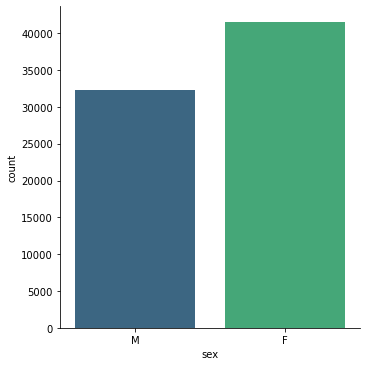

CAR
N(%%):	67.52395018902695
	 default rate(%%):	13.696018622571843
Y(%%):	32.47604981097305
	 default rate(%%):	10.627112279384153
Найдены статистически значимые различия


<Figure size 432x288 with 0 Axes>

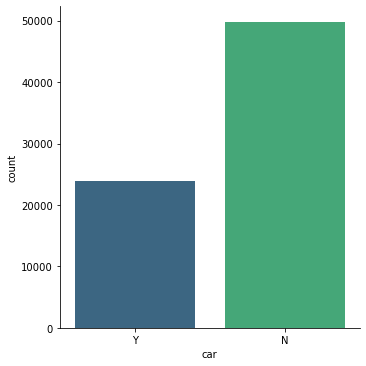

CAR_TYPE
N(%%):	81.01871299069093
	 default rate(%%):	13.625796524560553
Y(%%):	18.98128700930907
	 default rate(%%):	8.745002855511135
Найдены статистически значимые различия


<Figure size 432x288 with 0 Axes>

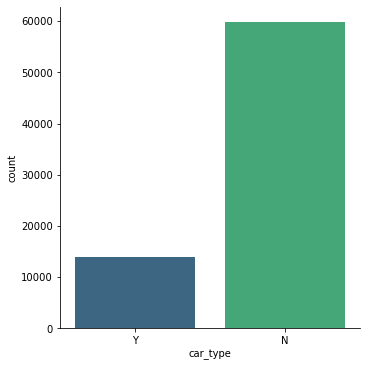

GOOD_WORK
0(%%):	83.5106166750227
	 default rate(%%):	13.340905403212721
1(%%):	16.489383324977304
	 default rate(%%):	9.450242419262059
Найдены статистически значимые различия


<Figure size 432x288 with 0 Axes>

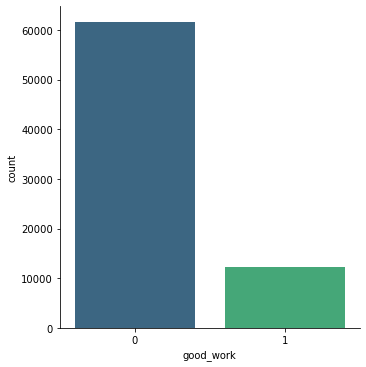

FOREIGN_PASSPORT
N(%%):	85.00521687285736
	 default rate(%%):	13.632378492978178
Y(%%):	14.994783127142645
	 default rate(%%):	7.410084944876197
Найдены статистически значимые различия


<Figure size 432x288 with 0 Axes>

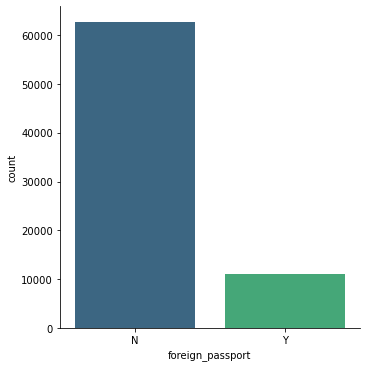

DEFAULT
0(%%):	87.3006409300939
	 default rate(%%):	0.0
1(%%):	12.699359069906096
	 default rate(%%):	100.0
Статистически значимые различия не найдены. Данные не несут ценности.


<Figure size 432x288 with 0 Axes>

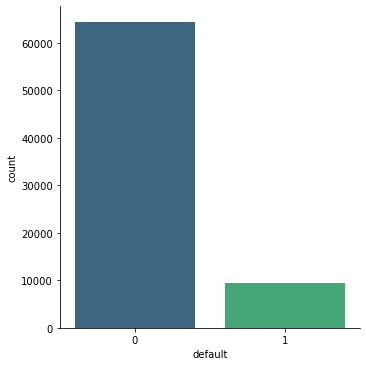

In [15]:
for column in bin_cols:
    summary(train, column)

In [16]:
print('Необходимо перекодировать: \t', obj_cols(train, bin_cols))

Необходимо перекодировать: 	 ['sex', 'car', 'car_type', 'foreign_passport']


### Вывод

За исключением пола, признаки распределены не равномерно. Тем не менее, пропорция меньшинства в этих случаях более 10%% и нет необходимости изменять выборку.

Все признаки несут ценность для модели, доли дефолтных клиентов в них довольно заметно отличаются.

Ряд признаков необходимо перекотировать в числовой формат для дальнейшего использования.

In [17]:
label_encoder = LabelEncoder()

In [18]:
# Кодировка бинарных столбцов
for column in obj_cols(train, bin_cols):
    train[column] = label_encoder.fit_transform(train[column])
    print(column.upper())
    print(dict(enumerate(label_encoder.classes_)))
    print()

SEX
{0: 'F', 1: 'M'}

CAR
{0: 'N', 1: 'Y'}

CAR_TYPE
{0: 'N', 1: 'Y'}

FOREIGN_PASSPORT
{0: 'N', 1: 'Y'}



In [19]:
#Результат кодировки
train[bin_cols].sample(5)

sex  car  car_type  good_work  foreign_passport  default
31541    0    0         0          0                 1        0
37557    0    0         0          1                 0        0
3098     0    1         0          0                 0        0
12907    1    1         1          0                 0        0
30221    0    0         0          0                 0        0

## Категориальные данные

EDUCATION
SCH(%%):	52.87650356501388
	 default rate(%%):	15.0591868244982
GRD(%%):	31.7925760627007
	 default rate(%%):	9.009201797560454
UGR(%%):	13.356555815598977
	 default rate(%%):	13.1519967400163
PGR(%%):	1.7103902465574485
	 default rate(%%):	6.443914081145586
ACD(%%):	0.26397431012899364
	 default rate(%%):	4.123711340206185
Найдены статистически значимые различия


<Figure size 432x288 with 0 Axes>

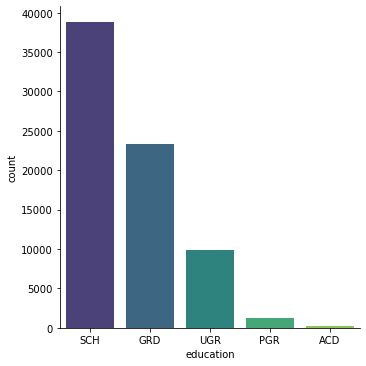

REGION_RATING
50(%%):	37.294543286494395
	 default rate(%%):	13.614068233840786
60(%%):	21.782137969349176
	 default rate(%%):	12.883359253499222
40(%%):	16.29696879361509
	 default rate(%%):	16.97015049472021
80(%%):	15.54086098727625
	 default rate(%%):	7.315371872002791
70(%%):	8.399842816298325
	 default rate(%%):	9.243426359090176
30(%%):	0.40650957330045123
	 default rate(%%):	19.0
20(%%):	0.27913657366630984
	 default rate(%%):	21.35922330097087
Найдены статистически значимые различия


<Figure size 432x288 with 0 Axes>

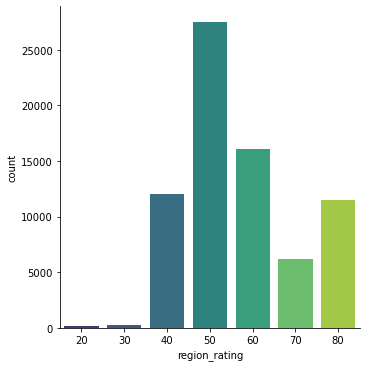

HOME_ADDRESS
2(%%):	54.1416550359761
	 default rate(%%):	15.514566022624887
1(%%):	44.15371481998401
	 default rate(%%):	9.289550406628818
3(%%):	1.704630144039892
	 default rate(%%):	11.605723370429253
Найдены статистически значимые различия


<Figure size 432x288 with 0 Axes>

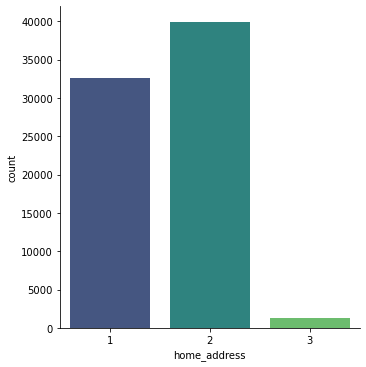

WORK_ADDRESS
3(%%):	60.920879686716624
	 default rate(%%):	14.795702751395718
2(%%):	27.786284366996846
	 default rate(%%):	10.250658343899346
1(%%):	11.292835946286536
	 default rate(%%):	7.415406767458603
Найдены статистически значимые различия


<Figure size 432x288 with 0 Axes>

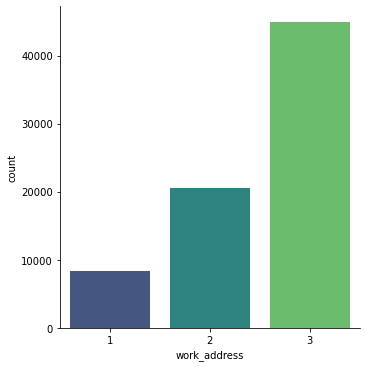

SNA
1(%%):	64.09436442228214
	 default rate(%%):	9.820088370224731
4(%%):	15.920269922356672
	 default rate(%%):	21.15073623287088
2(%%):	14.398569086301983
	 default rate(%%):	14.982119329945418
3(%%):	5.586796569059201
	 default rate(%%):	15.765219500363814
Найдены статистически значимые различия


<Figure size 432x288 with 0 Axes>

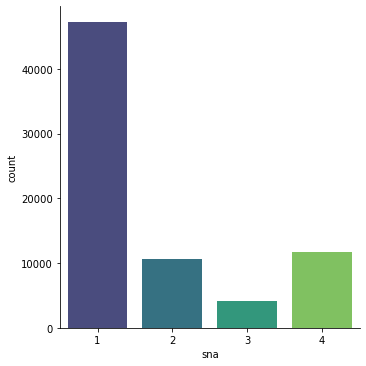

FIRST_TIME
3(%%):	42.35152237835201
	 default rate(%%):	12.026875699888018
4(%%):	25.389232916435184
	 default rate(%%):	8.203020761061003
1(%%):	16.58423555874741
	 default rate(%%):	18.612631750960045
2(%%):	15.6750091464654
	 default rate(%%):	15.542876901798063
Найдены статистически значимые различия


<Figure size 432x288 with 0 Axes>

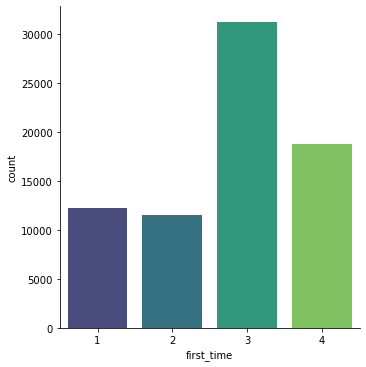

In [20]:
for column in cat_cols:
    summary(train, column)

In [21]:
print('Необходимо перекодировать: \t', obj_cols(train, cat_cols))

Необходимо перекодировать: 	 ['education']


In [22]:
print('EDUCATION')
print('default rate (средний): \t\t', train.default.mean()*100)
print('default rate (для пропущеных): \t', train[train.education.isna() == True].default.mean()*100)

EDUCATION
default rate (средний): 		 12.699359069906096
default rate (для пропущеных): 	 11.400651465798045


### Вывод

EDUCATION:

    Судя по значениям default rate для распределения, доля людей с категорией образования не отображает его уровень. Предпологаемая рассшифровка признака:

        SCH = school
        UGR = undergraduate
        GRD = graduate
        PGR = postgraduate
        ACD = advanced college degree
    
    Таким образом прризнак имеет смысл перекодировать в ручную. Что касается пропущенных значений, для них default rate ниже среднего по выборке. Что подтверждает то, что имеет смысл предсказать пропущенные значения, и мало вероятно, что они говорят об отсутствии образования. В дальнейшем для предсказания признака, необходимо сместить выборку для увеличения доли 'PGR' и'ACD'.

REGION_RATING:

    Признак имеет явную линейную зависимость с default rate. Так же, заметно, что ег распеределение условно нормально. Иммет смысл перенести его в числовые переменные.
    
Остальные признаки несут ценность для модели. Имееются низкие доли знвчений для признаков HOME_ADDRESS и SNA. Но, в этих случаях наблюдается отклонение default rate, и недооценка моделью этих значений может быть оправдана. 

In [23]:
# Перенос region_rating
cat_cols.remove('region_rating')
num_cols.append('region_rating')

In [24]:
# Кодировка education
mapping_dict = {'SCH': 1, 'UGR': 2, 'GRD':3, 'PGR':4, 'ACD':5}
train['education'] = train.education.map(mapping_dict)

In [25]:
#Результат кодировки
train[cat_cols].sample(5)

education  home_address  work_address  sna  first_time
64093        1.0             2             3    1           4
19541        1.0             2             3    1           3
71934        3.0             1             2    1           3
67855        1.0             2             3    1           4
23635        1.0             1             3    1           2

## Числовые данные

In [26]:
# Функция расчитывает кол-во выбросов по столбцам и их долю
def outbursts(df, col):
    Q25 = df[col].quantile(0.25)
    Q75 = df[col].quantile(0.75)
    IQR = Q75 - Q25
    lowest = Q25 - 1.5*IQR
    highest = Q75 + 1.5*IQR
    amount = df[(df[col] < lowest)|(df[col] > highest)].count()[0]
    ratio = amount/df.shape[0]
    return amount, ratio, lowest, highest

In [27]:
#Функция выводит основную информацию и график признака
def sum_up(df, col):
    print(col.upper())
    print(df[col].describe()[1:])
    print('Кол-во выбросов: {} \t (%%: {})'.format(outbursts(df, col)[0],outbursts(df, col)[1]*100))
    print()
    plt.figure()
    sns.displot(data=df, x=col, kde=True, palette = 'viridis')
    plt.show()
    plt.figure()
    sns.boxplot(data = df,  y = col, x = 'default', palette = 'viridis')
    plt.show()

AGE
mean    39.280641
std     11.520378
min     21.000000
25%     30.000000
50%     37.000000
75%     48.000000
max     72.000000
Name: age, dtype: float64
Кол-во выбросов: 0 	 (%%: 0.0)



<Figure size 432x288 with 0 Axes>

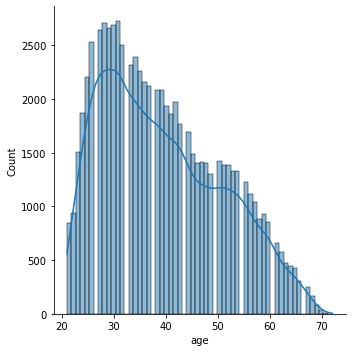

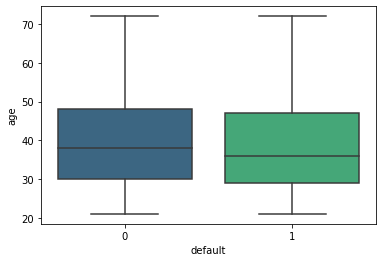

DECLINE_APP_CNT
mean     0.275749
std      0.804272
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max     33.000000
Name: decline_app_cnt, dtype: float64
Кол-во выбросов: 12585 	 (%%: 17.05307659995393)



<Figure size 432x288 with 0 Axes>

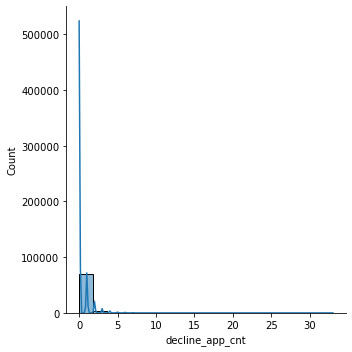

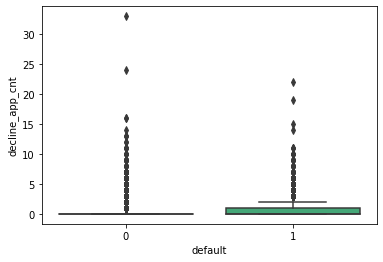

SCORE_BKI
mean   -1.904724
std     0.498231
min    -3.624586
25%    -2.259534
50%    -1.920823
75%    -1.569831
max     0.199773
Name: score_bki, dtype: float64
Кол-во выбросов: 351 	 (%%: 0.47561620076152794)



<Figure size 432x288 with 0 Axes>

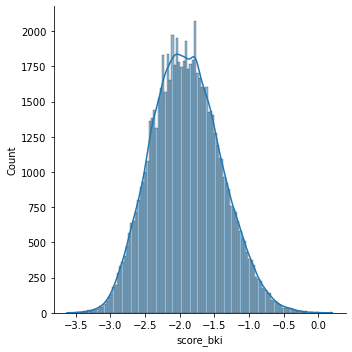

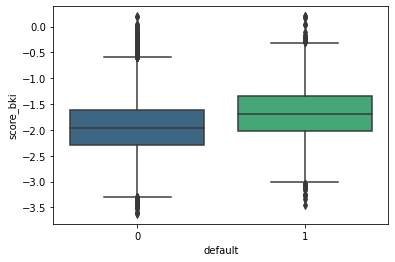

BKI_REQUEST_CNT
mean     2.000339
std      2.252073
min      0.000000
25%      0.000000
50%      1.000000
75%      3.000000
max     53.000000
Name: bki_request_cnt, dtype: float64
Кол-во выбросов: 1755 	 (%%: 2.3780810038076394)



<Figure size 432x288 with 0 Axes>

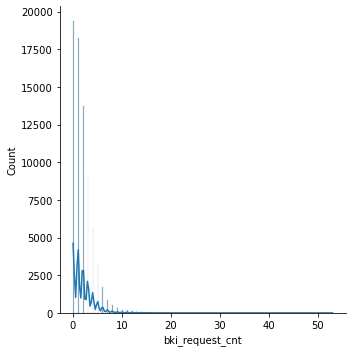

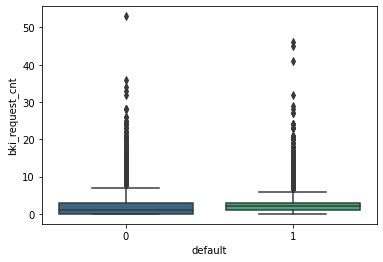

INCOME
mean      41099.775417
std       46166.322400
min        1000.000000
25%       20000.000000
50%       30000.000000
75%       48000.000000
max     1000000.000000
Name: income, dtype: float64
Кол-во выбросов: 4695 	 (%%: 6.361874822152061)



<Figure size 432x288 with 0 Axes>

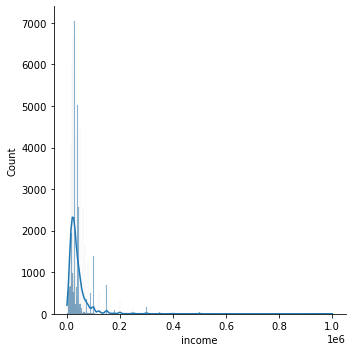

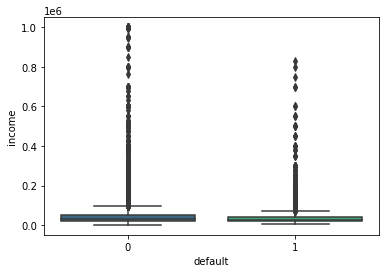

REGION_RATING
mean    56.725701
std     13.055717
min     20.000000
25%     50.000000
50%     50.000000
75%     60.000000
max     80.000000
Name: region_rating, dtype: float64
Кол-во выбросов: 11975 	 (%%: 16.22650713424301)



<Figure size 432x288 with 0 Axes>

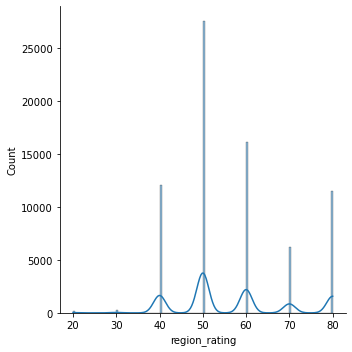

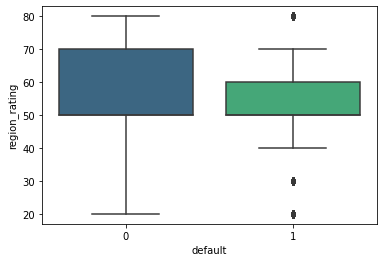

In [28]:
for col in num_cols:
    sum_up(train, col)

Из 6 числовых переменных: 2 - нормальныо распределены, 4 - логнормально. Следовательно, необходимо преобразовать столбцы: age, decline_app_cnt, bki_request_cnt, income. Вместе с тем, для первых двух минимальное значение равно 0. Так же, можно уменьшить размерность region_rating.

Имеются выбросы в данных.

In [29]:
# Предобработка столбцов, имеющих значение 0
for col in ['decline_app_cnt', 'bki_request_cnt']:
    train[col] = train[col].apply(lambda x: x+1)

In [30]:
# Нормализация
for col in ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']:
    train[col] = stats.boxcox(train[col])[0]

In [31]:
# Изменение размерности
train['region_rating'] = train['region_rating']/100

AGE
mean    3.240389
std     0.232844
min     2.769830
25%     3.060851
50%     3.228933
75%     3.434468
max     3.747995
Name: age, dtype: float64
Кол-во выбросов: 0 	 (%%: 0.0)



<Figure size 432x288 with 0 Axes>

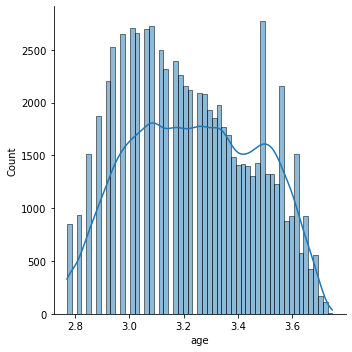

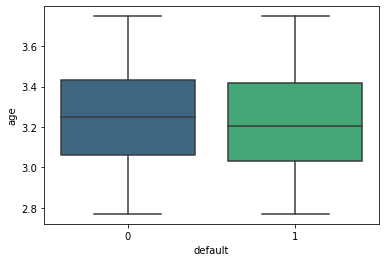

DECLINE_APP_CNT
mean    0.026804
std     0.059116
min     0.000000
25%     0.000000
50%     0.000000
75%     0.000000
max     0.158546
Name: decline_app_cnt, dtype: float64
Кол-во выбросов: 12585 	 (%%: 17.05307659995393)



<Figure size 432x288 with 0 Axes>

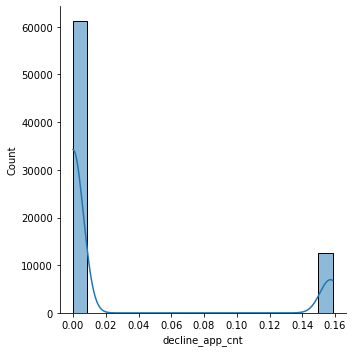

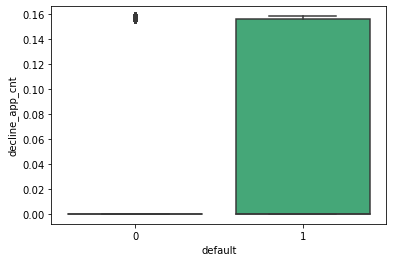

SCORE_BKI
mean   -1.904724
std     0.498231
min    -3.624586
25%    -2.259534
50%    -1.920823
75%    -1.569831
max     0.199773
Name: score_bki, dtype: float64
Кол-во выбросов: 351 	 (%%: 0.47561620076152794)



<Figure size 432x288 with 0 Axes>

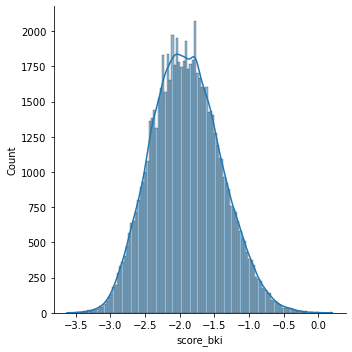

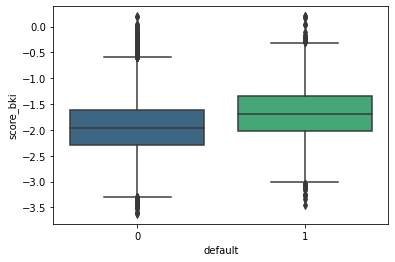

BKI_REQUEST_CNT
mean    0.807436
std     0.587435
min     0.000000
25%     0.000000
50%     0.663986
75%     1.272896
max     3.141523
Name: bki_request_cnt, dtype: float64
Кол-во выбросов: 0 	 (%%: 0.0)



<Figure size 432x288 with 0 Axes>

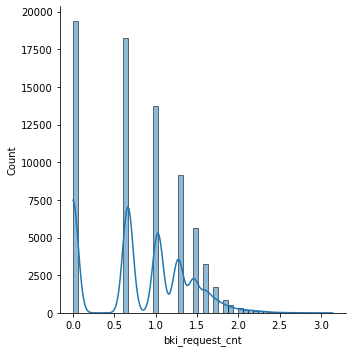

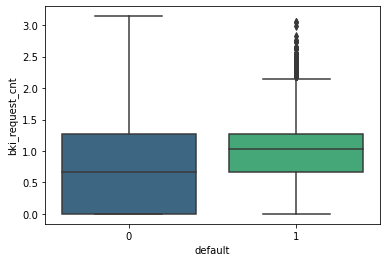

INCOME
mean    5.670380
std     0.179519
min     4.553056
25%     5.560409
50%     5.668952
75%     5.787797
max     6.402578
Name: income, dtype: float64
Кол-во выбросов: 1619 	 (%%: 2.193796663911435)



<Figure size 432x288 with 0 Axes>

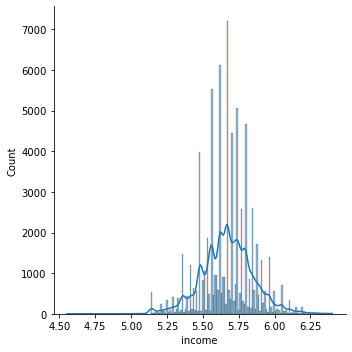

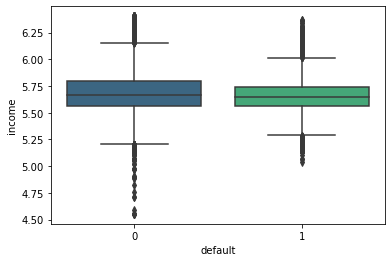

REGION_RATING
mean    0.567257
std     0.130557
min     0.200000
25%     0.500000
50%     0.500000
75%     0.600000
max     0.800000
Name: region_rating, dtype: float64
Кол-во выбросов: 11975 	 (%%: 16.22650713424301)



<Figure size 432x288 with 0 Axes>

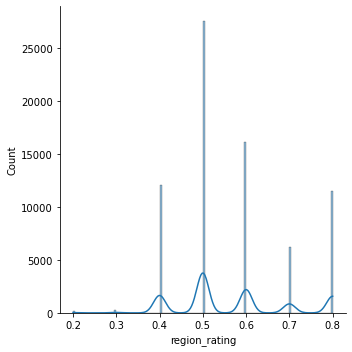

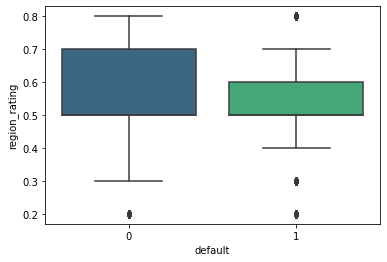

In [32]:
for col in num_cols:
    sum_up(train, col)

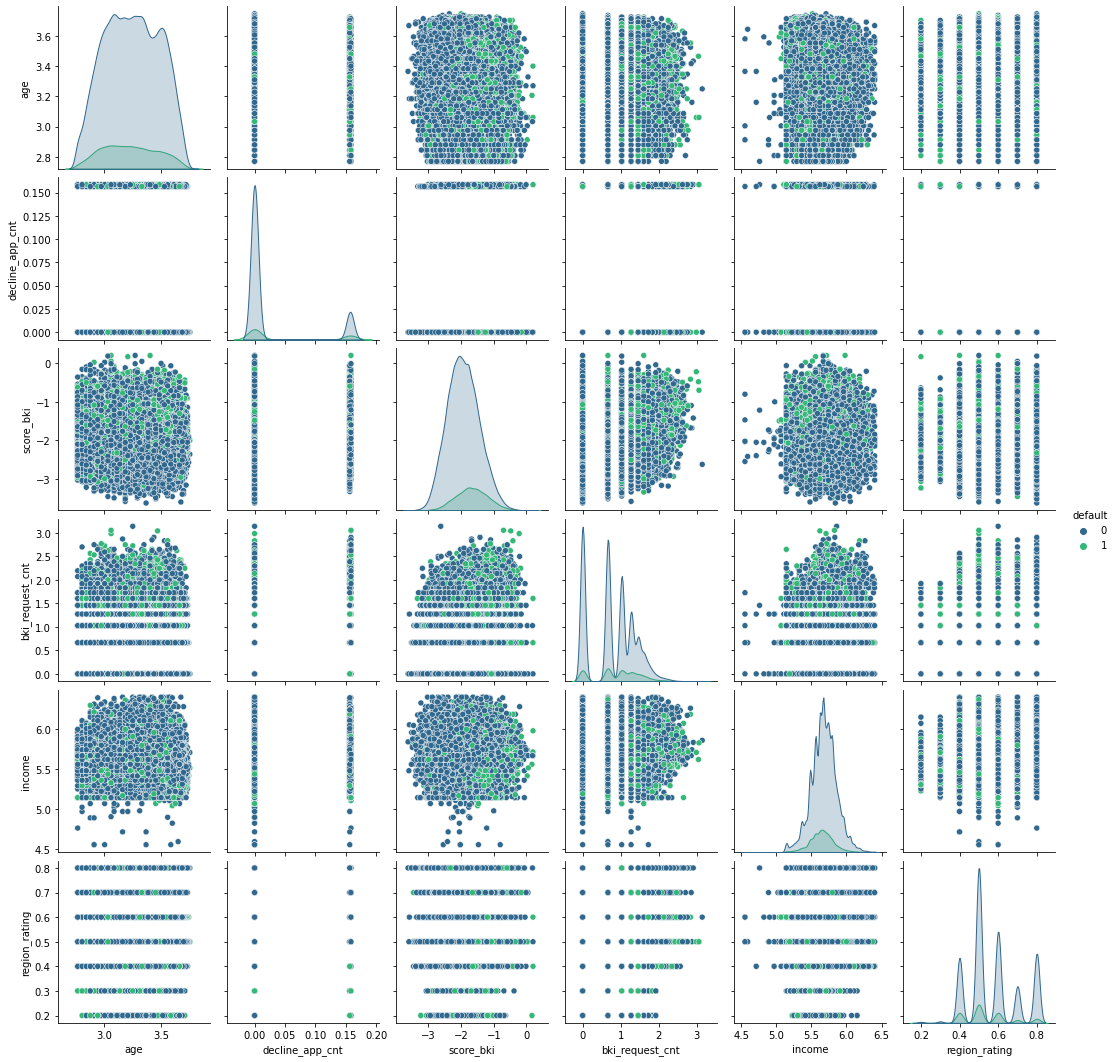

In [33]:
sns.pairplot(train[num_cols+['default']], hue = 'default', palette = 'viridis')

Обработка данных позволила привести к нормальному распределению параметры 'age' и 'income'. Так же, удалось снизить кол-во выбросов данных. В ходе тестирования выяснилось, что очистка от выбросов в 'score_bki' и 'income' снижает ROC AUC, как на тестовой, так и на валидационной выборках. 'decline_app_cnt' после нормализации имеет два ярко выраженных пика, что позволяет перекодировать признак в бинарный.

DECLINE_APP_CNT
0(%%):	82.94692340004607
	 default rate(%%):	10.95337667853759
1(%%):	17.05307659995393
	 default rate(%%):	21.191895113230036
Найдены статистически значимые различия


<Figure size 432x288 with 0 Axes>

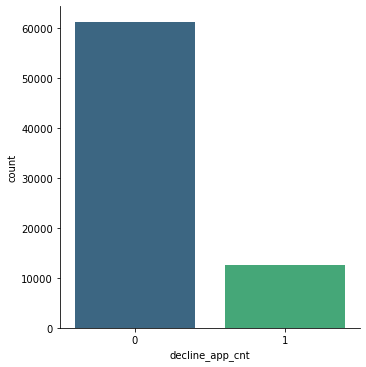

In [34]:
# Перекодировка decline_app_cnt
train['decline_app_cnt'] = train.decline_app_cnt.apply(lambda x: 1 if x>0 else 0)
summary(train, 'decline_app_cnt')

In [35]:
# Перенос decline_app_cnt
num_cols.remove('decline_app_cnt')
bin_cols.append('decline_app_cnt')

<AxesSubplot:>

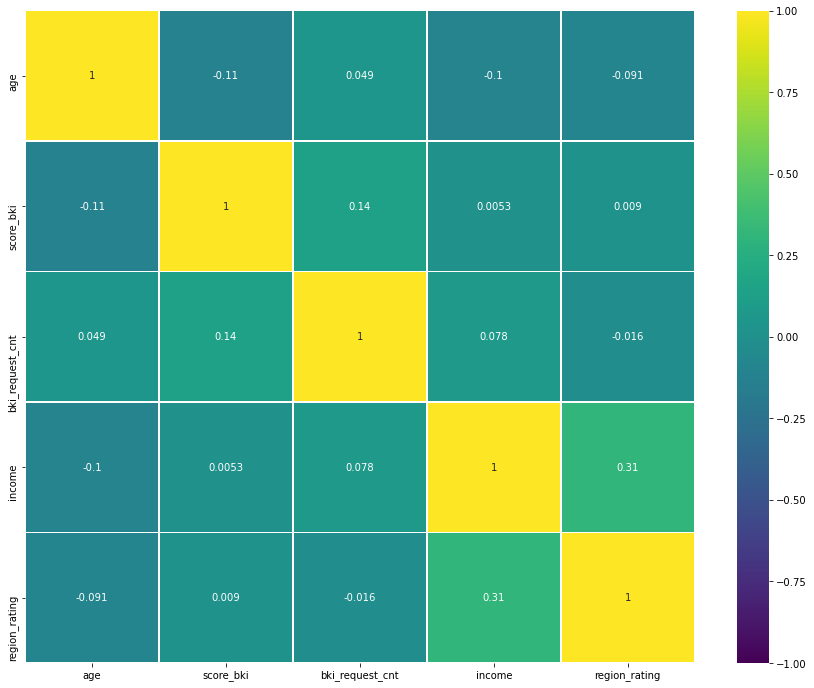

In [36]:
# Корреляционная матрица
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(train[num_cols].corr(), vmin=-1, vmax=1, annot=True, linewidths=.5, cmap='viridis')

### Вывод

За исключением 'bki_request_cnt', числовые данные приведены к нормальному распределнию. В данных сохраняются выбросы.

Построенние коррелиционной матрицы не выявило высоких значений, которые могли бы препядствовать работе модели.

## Время/дата

In [37]:
train['app_year'] = train.app_date.dt.year
train['app_month'] = train.app_date.dt.month
train['app_week_day'] = train.app_date.dt.dayofweek
train['timestamp'] = train.app_date.values.astype(np.int64) // 10 ** 9

APP_YEAR
2014(%%):	100.0
	 default rate(%%):	12.699359069906096
Статистически значимые различия не найдены. Данные не несут ценности.


<Figure size 432x288 with 0 Axes>

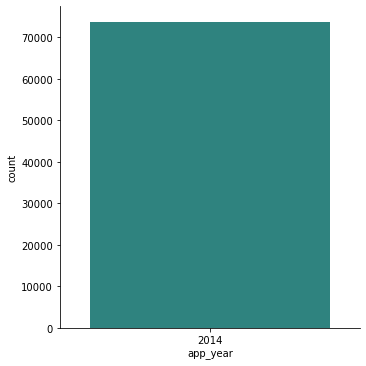

APP_MONTH
3(%%):	28.696865811189852
	 default rate(%%):	12.753801114363963
2(%%):	24.428515291535117
	 default rate(%%):	13.262702462835588
4(%%):	23.961029282239597
	 default rate(%%):	10.59209410167958
1(%%):	22.913589615035434
	 default rate(%%):	14.23418095801301
Найдены статистически значимые различия


<Figure size 432x288 with 0 Axes>

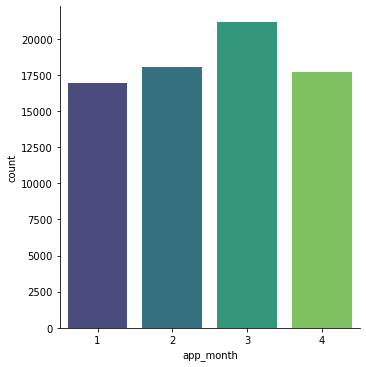

APP_WEEK_DAY
1(%%):	16.498868548354313
	 default rate(%%):	12.738173455978973
0(%%):	16.292903697882085
	 default rate(%%):	12.70791749833666
2(%%):	15.908074635157657
	 default rate(%%):	12.427597955706984
3(%%):	15.73869564628247
	 default rate(%%):	13.198450279810588
4(%%):	15.26172441360994
	 default rate(%%):	11.99502796768179
5(%%):	11.153267659453379
	 default rate(%%):	13.096829060867451
6(%%):	9.146465399260153
	 default rate(%%):	12.918518518518518
Статистически значимые различия не найдены. Данные не несут ценности.


<Figure size 432x288 with 0 Axes>

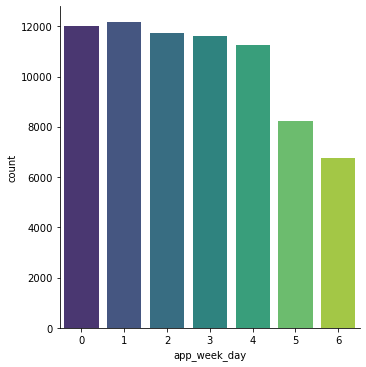

In [38]:
for category in ['app_year', 'app_month', 'app_week_day']:
    summary(train, category)

TIMESTAMP
mean    1.393808e+09
std     2.775331e+06
min     1.388534e+09
25%     1.391386e+09
50%     1.393891e+09
75%     1.396224e+09
max     1.398816e+09
Name: timestamp, dtype: float64
Кол-во выбросов: 0 	 (%%: 0.0)



<Figure size 432x288 with 0 Axes>

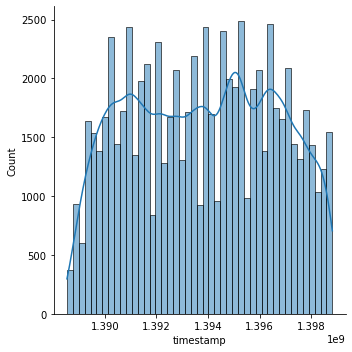

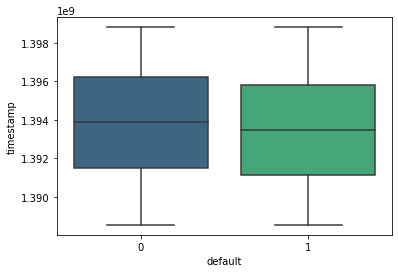

In [39]:
sum_up(train, 'timestamp')

In [40]:
num_cols.append('timestamp')

### Вывод

Данные предоставлены за 4 месяца 2014 года. Найдены статистически значимые различия между месяцами. Default rate для месяцев снижается. Аналогично 'timestamp' ниже для дефолтных клиентов. Не ясно, является ли эта закономерность отображение объективного тренда. В любом случае, иммет смысл сохранить данные. Насколько данные переменные полезны для модели будет проанализировано позже.

Столбец 'app_month' иммет 4 уникальных значения и может рассмотриваться как категориальный признак.

Столбцы 'app_year' и 'app_week_day' будут удалены, т.к. не несут ценности.

In [41]:
cat_cols.append('app_month')

In [42]:
train.drop(['app_date', 'app_year', 'app_week_day'], axis = 1, inplace = True)

## Итоговый DataFrame

In [43]:
train.sample(5)

education  sex       age  car  car_type  decline_app_cnt  good_work  \
58092        3.0    0  2.879550    0         0                0          0   
64678        1.0    1  3.033470    0         0                0          0   
36651        3.0    0  3.087277    1         1                0          0   
37428        1.0    0  3.434468    0         0                1          0   
31157        3.0    1  3.511833    1         1                0          1   

       score_bki  bki_request_cnt  region_rating  home_address  work_address  \
58092  -1.421677         0.663986            0.5             1             2   
64678  -2.024410         0.663986            0.6             2             3   
36651  -2.064468         1.605396            0.5             1             2   
37428  -1.785681         0.663986            0.4             3             3   
31157  -2.700987         1.831301            0.8             2             3   

         income  sna  first_time  foreign_passport  default  app_month  \
58092  5.560409    1           2                 0        1          2   
64678  5.560409    4           1                 0        0          4   
36651  5.807320    1           4                 0        0          1   
37428  5.668952    1           1                 0        0          2   
31157  5.894097    1           4                 0        0          4   

        timestamp  
58092  1392768000  
64678  1396656000  
36651  1390521600  
37428  1392249600  
31157  1397433600

In [44]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   education         73492 non-null  float64
 1   sex               73799 non-null  int64  
 2   age               73799 non-null  float64
 3   car               73799 non-null  int64  
 4   car_type          73799 non-null  int64  
 5   decline_app_cnt   73799 non-null  int64  
 6   good_work         73799 non-null  int64  
 7   score_bki         73799 non-null  float64
 8   bki_request_cnt   73799 non-null  float64
 9   region_rating     73799 non-null  float64
 10  home_address      73799 non-null  int64  
 11  work_address      73799 non-null  int64  
 12  income            73799 non-null  float64
 13  sna               73799 non-null  int64  
 14  first_time        73799 non-null  int64  
 15  foreign_passport  73799 non-null  int64  
 16  default           73799 non-null  int64 

Удаляем 'default' из категориальных признаков, т. к. он не участвует в обработке данных

In [45]:
bin_cols.remove('default')

# Заполнение пропусков 'education'

EDUCATION
1.0(%%):	52.87650356501388
	 default rate(%%):	15.0591868244982
3.0(%%):	31.7925760627007
	 default rate(%%):	9.009201797560454
2.0(%%):	13.356555815598977
	 default rate(%%):	13.1519967400163
4.0(%%):	1.7103902465574485
	 default rate(%%):	6.443914081145586
5.0(%%):	0.26397431012899364
	 default rate(%%):	4.123711340206185
Найдены статистически значимые различия


<Figure size 432x288 with 0 Axes>

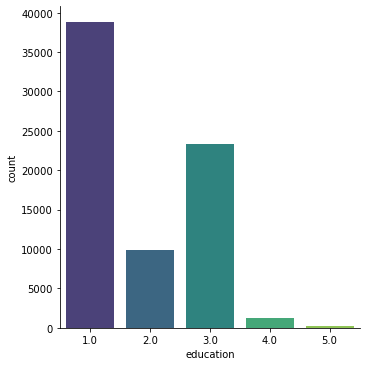

In [46]:
summary(train, 'education')

## Undersampling

Так как, в данных доля 4го и 5го классов (PGR и ACD) крайне мала, необходимо устранить диссбаланс выборки.

Метод undersampling выбран в целях быстродействия (переменная не является целевой и пропусков в ней не очень много).

In [47]:
# Функция возвращает сбаласированную выборку, сохраняя пропорции среди преобладающих значений
def undersampling(df, col, min_frac = 0.1):
    vc = df[col].dropna().value_counts(ascending=True)
    min_value = vc.min()
    to_distribute = min_value/min_frac*(1-len(vc)*min_frac)
    parts = []
    count = 0
    for i in vc.index:
        if vc[i]/vc[i:].sum() < min_frac:
            parts.append(df[df[col] == i].copy().head(min_value))
            count += 1
        else:
            add_value = vc[i]/vc.iloc[count:].sum()*to_distribute
            parts.append(df[df[col] == i].copy().head(min_value+int(add_value)))
    sample = pd.concat(parts)
    return sample

education  sex       age  car  car_type  decline_app_cnt  good_work  \
651          3.0    1  3.005067    1         1                0          1   
3293         4.0    1  3.112813    1         1                0          0   
71500        5.0    0  3.207100    1         1                0          1   
40           1.0    1  3.554612    1         0                0          0   
621          1.0    1  3.481858    0         0                0          0   

       score_bki  bki_request_cnt  region_rating  home_address  work_address  \
651    -2.163473         1.457966            0.4             1             2   
3293   -1.928942         0.663986            0.8             2             3   
71500  -2.390700         0.663986            0.7             2             3   
40     -1.318052         0.663986            0.5             1             2   
621    -2.015939         0.000000            0.6             1             2   

         income  sna  first_time  foreign_passport  default  app_month  \
651    5.935775    1           4                 0        0          1   
3293   5.970248    1           4                 1        0          1   
71500  5.742558    1           3                 0        0          1   
40     5.860684    1           2                 0        0          2   
621    5.479840    1           3                 0        0          2   

        timestamp  
651    1389571200  
3293   1390694400  
71500  1391040000  
40     1392595200  
621    1391212800

EDUCATION
1.0(%%):	36.9778236204229
	 default rate(%%):	14.504881450488144
3.0(%%):	26.19907168643631
	 default rate(%%):	8.46456692913386
2.0(%%):	16.812790097988653
	 default rate(%%):	10.429447852760736
5.0(%%):	10.00515729757607
	 default rate(%%):	4.123711340206185
4.0(%%):	10.00515729757607
	 default rate(%%):	7.731958762886598
Найдены статистически значимые различия


<Figure size 432x288 with 0 Axes>

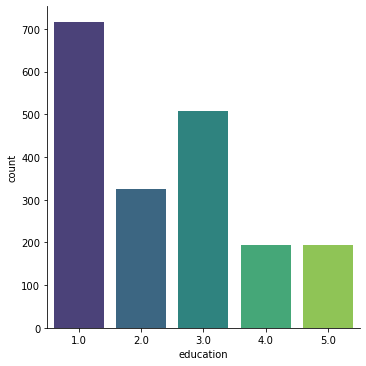

In [48]:
# Применение функции, отображение итога
edu_sample = undersampling(train, 'education')
display(edu_sample.sample(5))
summary(edu_sample, 'education')

## Feature selection

In [49]:
# Функция измеряет взаимную информацию для ряда переменных
def mi_class(features, target):
    mi_scores = mutual_info_classif(features, target, random_state = RC)
    mi_scores = pd.Series(mi_scores, index=features.columns)
    return mi_scores

<AxesSubplot:>

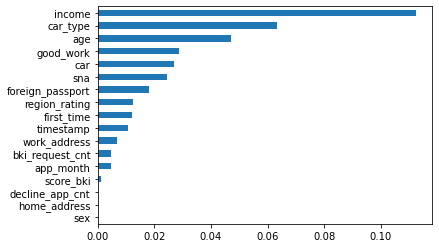

In [50]:
# Расчет взаимной иформации
features = edu_sample.copy().drop(['education','default'], axis = 1)
target = edu_sample.education
mi_scores = mi_class(features, target)
mi_scores = mi_scores.sort_values()
mi_scores.plot(kind = 'barh')

In [51]:
# Фунция возвращает параметры из списка, для который MI score выше определенного значения
def mi_test(cols, value = 0.01):
    useful_cols = []
    for col in cols:
        if mi_scores[col]>value:
            useful_cols.append(col)
    return useful_cols

In [52]:
# Создание списков переменных, которые ценны для предсказания education
edu_bin_cols = mi_test(bin_cols, 0.01)
print(edu_bin_cols)
edu_num_cols = mi_test(num_cols, 0.01)
print(edu_num_cols)
edu_cat_cols = mi_test(cat_cols[1:], 0.01)
print(edu_cat_cols)

['car', 'car_type', 'good_work', 'foreign_passport']
['age', 'income', 'region_rating', 'timestamp']
['sna', 'first_time']


## Классификаторы

In [53]:
# Создание предобработки признаков (dummy-переменные, стандартизация)
edu_OHE = OneHotEncoder(sparse = False)
edu_OHE.fit(edu_sample[edu_cat_cols].values)
edu_SS = StandardScaler()
edu_SS.fit(edu_sample[edu_num_cols].values)

StandardScaler()

In [54]:
# Применеие предобработки
W_cat = edu_OHE.transform(edu_sample[edu_cat_cols].values)
W_num = edu_SS.transform(edu_sample[edu_num_cols].values)
W = np.hstack([W_num, edu_sample[edu_bin_cols].values, W_cat])
z = edu_sample.education.values

In [55]:
# Разбиение выборки
W_train, W_add, z_train, z_add = train_test_split(W, z, test_size=0.2, random_state=RC)
W_test, W_valid, z_test, z_valid = train_test_split(W_add, z_add, test_size=0.5, random_state=RC)

In [56]:
# Значения гиперпараметров для тестирования LogisticRegression
C = [0.01, 0.1, 1, 10]
penalty = ['l1', 'l2']
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
warm_start = [True, False]

# Значения гиперпараметров для тестирования KNeighborsClassifier
n_neighbors = [3, 5, 7, 10]
weights = ['uniform', 'distance']
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']

# Значения гиперпараметров для тестирования DecisionTreeClassifier
criterion = ['gini', 'entropy']
splitter = ['best', 'random']
max_depth = [3, 5, 7, 10]

# Словарь для более удобной работы с моделями в цикле
edu_models = {'LR': {'model': LogisticRegression(random_state=RC, max_iter=25), 
                     'params': {'C': C, 'penalty': penalty, 'solver': solver, 
                                'warm_start': warm_start}},
              'KN' : {'model' : KNeighborsClassifier(), 
                      'params': {'n_neighbors': n_neighbors,  'weights': weights, 
                                 'algorithm': algorithm}}, 
              'DT' : {'model': DecisionTreeClassifier(random_state=RC), 
                      'params': {'criterion': criterion,  'splitter': splitter, 
                                 'max_depth': max_depth}}
             }

Benchmark F1 (random): 		 0.177118144547511
Benchmark F1 (most common): 	 0.17272006344171292

LogisticRegression(max_iter=25, random_state=42)
Лучшие параметры: 		 {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
F1 score: 			 0.4156476933596077
Confusion matrix:


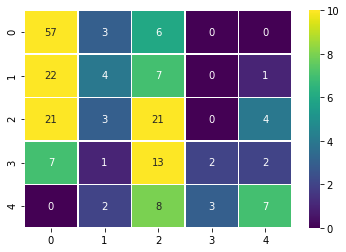

KNeighborsClassifier()
Лучшие параметры: 		 {'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'distance'}
F1 score: 			 0.3370690028588755
Confusion matrix:


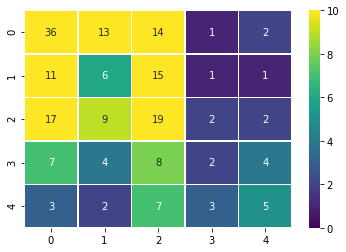

DecisionTreeClassifier(random_state=42)
Лучшие параметры: 		 {'criterion': 'gini', 'max_depth': 7, 'splitter': 'best'}
F1 score: 			 0.36323771659496473
Confusion matrix:


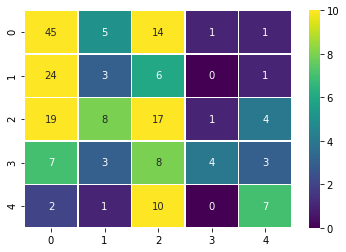

In [57]:
# Значения добавлены, чтобы оценить нужно ли моделировать пустые значения
print('Benchmark F1 (random): \t\t', f1_score(z_test,
                                              np.random.randint(1, 6, len(z_test)), 
                                              average='weighted'))
print('Benchmark F1 (most common): \t', f1_score(z_test, 
                                                 [train.education.value_counts().index[0]] * len(z_test), 
                                                 average='weighted'))
print()

for k in edu_models.keys():
    model = edu_models[k]['model']
    hyperparameters = edu_models[k]['params']
    print(model)
    
    # Поик оптимальных параметров для каждой модели с точки зрения F1 score
    gscv = GridSearchCV(model, hyperparameters, cv=5, verbose=0, 
                        scoring='f1_weighted')
    search = gscv.fit(W_train, z_train)
    pred = search.best_estimator_.predict(W_test)
    
    #  Предсказание тестовой выборки моделями
    print('Лучшие параметры: \t\t', search.best_params_)
    print('F1 score: \t\t\t', f1_score(
        z_test, pred, average='weighted'))
    print('Confusion matrix:')
    sns.heatmap(confusion_matrix(z_test, pred), vmin=0, 
                vmax=10, annot=True, linewidths=.5, cmap='viridis')
    plt.show()
    
    # Добавление оптимальных моделей в словарь
    edu_models[k]['best_model'] = search.best_estimator_

Модели не обладают высокой точностью предсказания. Тем не менее, их результат выше, чем заполние переменной случайной величиной или самым частовстречающимся значением (в данном случае F1 score для последнего занижен из-за смещения выборки).

Чтобы убедиться, что относительное качество моделей не характерно лишь для тестовой выборки, имеет смысл воспользоваться также валидационной.

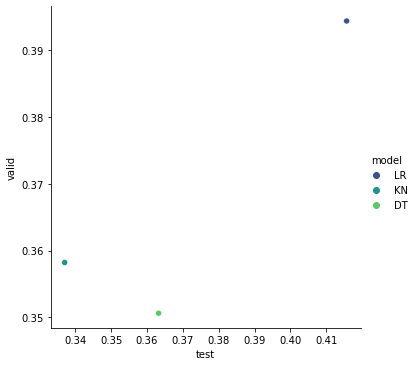

In [58]:
# Смотрим F1 score для тестовой и валидационной выборки
edu_F1_test = []
edu_F1_valid = []

for k in edu_models.keys():
    model = edu_models[k]['best_model']
    edu_F1_test.append(f1_score(z_test, model.predict(W_test), average='weighted'))
    edu_F1_valid.append(f1_score(z_valid, model.predict(W_valid), average='weighted'))

edu_F1 = pd.DataFrame({'test':edu_F1_test, 'valid':edu_F1_valid, 'model':edu_models.keys()})
sns.relplot(data=edu_F1, x='test', y='valid', hue='model', palette = 'viridis')

Модели показывают себя лучше на валидационной выборке. Исключением является KNeighborsClassifier, которая показывает себя лучше на валидационной выборке.

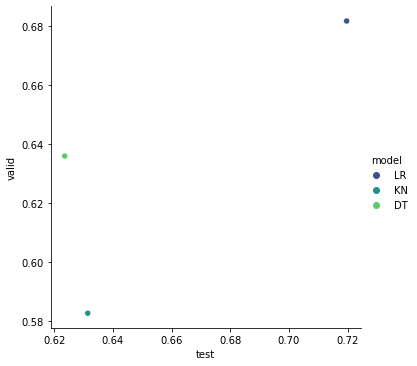

In [59]:
# Дополнительно, посмотрим ROC AUC для тестовой и валидационной выборки
edu_ROC_AUC_test = []
edu_ROC_AUC_valid = []

for k in edu_models.keys():
    model = edu_models[k]['best_model']
    edu_ROC_AUC_test.append(roc_auc_score(z_test, model.predict_proba(W_test), average='weighted', multi_class='ovr'))
    edu_ROC_AUC_valid.append(roc_auc_score(z_valid, model.predict_proba(W_valid), average='weighted', multi_class='ovr'))

edu_ROC_AUC = pd.DataFrame({'test':edu_ROC_AUC_test, 'valid':edu_ROC_AUC_valid, 'model':edu_models.keys()})
sns.relplot(data=edu_ROC_AUC, x='test', y='valid', hue='model', palette = 'viridis')

ROC AUC подверждает, что KNeighborsClassifier и DecisionTreeClassifier показывают себя хуже.

### Вывод

LogisticRegression является наилучшей из трех моделей.

В заключении необходимо убедиться, что 25ти итереаций достаточно для точных предсказаний:

In [60]:
# Измерение точности модели в зависимости от кол-ва итераций на тестовой выборке
start_time = time.time()
edu_lr_results_test = []
for n_iter in range(1, 51, 1):
    model = LogisticRegression(C=10, max_iter=n_iter, random_state=50, 
                               solver='sag', warm_start=True)
    model.fit(W_train, z_train)
    pred = model.predict(W_test)
    edu_lr_results_test.append(f1_score(z_test, pred, average='weighted'))
    print(('Processing: {} %'.format(n_iter*2)), end="\r")
print('Веремя выполнения кода: \t{} sec.'.format((time.time() - start_time)))

Веремя выполнения кода: 	1.2883038520812988 sec.


In [61]:
# Измерение точности модели в зависимости от кол-ва итераций на валидационной выборке
start_time = time.time()
edu_lr_results_valid = []
for n_iter in range(1, 51, 1):
    model = LogisticRegression(C=10, max_iter=n_iter, random_state=50, 
                               solver='sag', warm_start=True)
    model.fit(W_train, z_train)
    pred = model.predict(W_valid)
    edu_lr_results_valid.append(f1_score(z_valid, pred, average='weighted'))
    print(('Processing: {} %'.format(n_iter*2)), end="\r")
print('Веремя выполнения кода: \t{} sec.'.format((time.time() - start_time)))

Веремя выполнения кода: 	1.306128978729248 sec.


Лучший результат test (F1 = 0.4203895406279193) при max_iter = Int64Index([13], dtype='int64')
Лучший результат valid (F1 = 0.41418126226110114) при max_iter = Int64Index([6], dtype='int64')


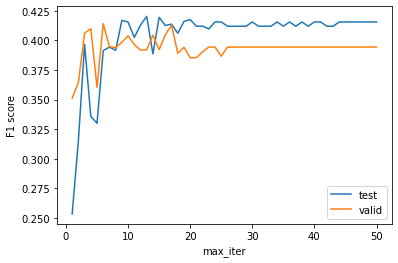

In [62]:
# Визуализация результатов
er_t = pd.Series(edu_lr_results_test, index = [x for x in range(1, 51, 1)])
print('Лучший результат test (F1 = {}) при max_iter = {}'.format(er_t.max(), er_t[er_t == er_t.max()].index))
er_v = pd.Series(edu_lr_results_valid, index = [x for x in range(1, 51, 1)])
print('Лучший результат valid (F1 = {}) при max_iter = {}'.format(er_v.max(), er_v[er_v == er_v.max()].index))

ax = sns.lineplot(x=range(1, 51, 1), y=er_t, label='test')
ax = sns.lineplot(x=range(1, 51, 1), y=er_v, label='valid')
ax.set(ylabel='F1 score', xlabel='max_iter')
plt.legend(loc='lower right')
plt.show()

В обоих случаях примерно к 25ти итерациям результаты выходят на плато, значит этого кол-ва вполне достаточно

Для заполнения пропусков будет использована:

In [63]:
edu_models['LR']['best_model']

LogisticRegression(C=10, max_iter=25, random_state=42, solver='newton-cg',
                   warm_start=True)

## Применение модели

In [64]:
# Выбираем данные с пропущенным 'education'
edu_na_sample = train[train.education.isna() == True].drop('education', axis = 1)

In [65]:
# Предобработка признаков
W_na_cat = edu_OHE.transform(edu_na_sample[edu_cat_cols].values)
W_na_num = edu_SS.transform(edu_na_sample[edu_num_cols].values)
W_na = np.hstack([W_na_num, edu_na_sample[edu_bin_cols].values, W_na_cat])

In [66]:
# Применение модели
edu_model = edu_models['LR']['best_model']
edu_model.fit(W, z)
edu_predictions = pd.Series(edu_model.predict(W_na), index = train[train.education.isna() == True].index)

In [67]:
# Функция возвращает 1, если ячейка в формате 'int' пуста
def isna(cell):
    if cell%1 != 0:
        return 1
    else:
        return 0 

In [68]:
# Создание признака, отмечающего пропуск в образовании
train['edu_isna'] = train.education.apply(isna)

In [69]:
# Функция возвращает предсказание для пропущенного значения
def filling(row):
    if row['edu_isna'] == 1:
        return edu_predictions[row.name]
    else:
        return row['education']

In [70]:
# Заполнение пропусков
train['education'] = train.apply(filling, axis = 1)

## Результаты

In [71]:
train[train.edu_isna == 1].sample(5)

education  sex       age  car  car_type  decline_app_cnt  good_work  \
42024        5.0    0  3.511833    0         0                0          1   
59653        1.0    0  3.207100    0         0                0          0   
67929        1.0    0  2.944877    0         0                1          0   
69682        1.0    1  3.329446    0         0                0          1   
19742        3.0    0  3.087277    1         0                0          0   

       score_bki  bki_request_cnt  region_rating  home_address  work_address  \
42024  -1.897680         1.272896            0.8             2             3   
59653  -1.702576         0.000000            0.4             2             3   
67929  -1.217280         1.831301            0.6             1             1   
69682  -1.182285         0.000000            0.5             1             2   
19742  -1.915120         1.457966            0.8             2             3   

         income  sna  first_time  foreign_passport  default  app_month  \
42024  5.742558    1           4                 1        0          3   
59653  5.668952    3           2                 0        0          1   
67929  5.479840    1           3                 0        0          1   
69682  5.531251    1           3                 0        1          3   
19742  6.073641    1           3                 0        0          3   

        timestamp  edu_isna  
42024  1395878400         1  
59653  1390694400         1  
67929  1390003200         1  
69682  1393891200         1  
19742  1394323200         1

EDUCATION
1.0(%%):	52.87650356501388
	 default rate(%%):	15.0591868244982
3.0(%%):	31.7925760627007
	 default rate(%%):	9.009201797560454
2.0(%%):	13.356555815598977
	 default rate(%%):	13.1519967400163
4.0(%%):	1.7103902465574485
	 default rate(%%):	6.443914081145586
5.0(%%):	0.26397431012899364
	 default rate(%%):	4.123711340206185
Найдены статистически значимые различия


<Figure size 432x288 with 0 Axes>

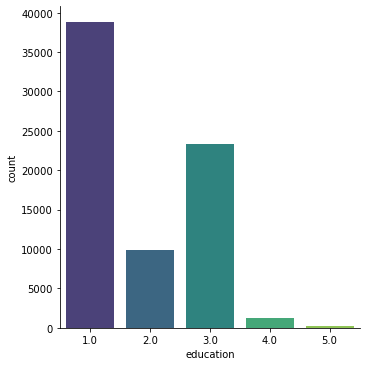

EDUCATION
1.0(%%):	63.51791530944625
	 default rate(%%):	13.333333333333334
3.0(%%):	22.80130293159609
	 default rate(%%):	8.571428571428571
2.0(%%):	6.840390879478828
	 default rate(%%):	14.285714285714285
5.0(%%):	5.211726384364821
	 default rate(%%):	0.0
4.0(%%):	1.6286644951140066
	 default rate(%%):	0.0
Найдены статистически значимые различия


<Figure size 432x288 with 0 Axes>

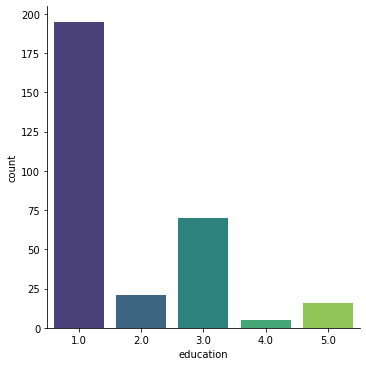

In [72]:
summary(train[train.edu_isna == 0], 'education')
summary(train[train.edu_isna == 1], 'education')

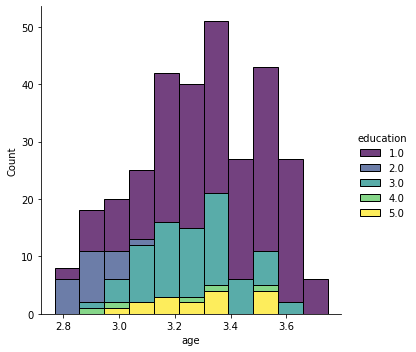

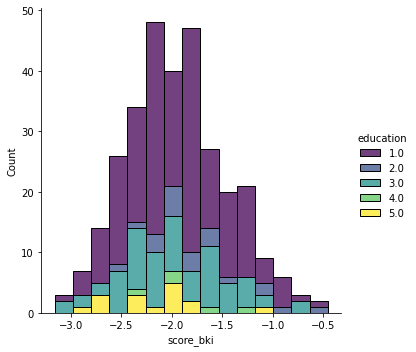

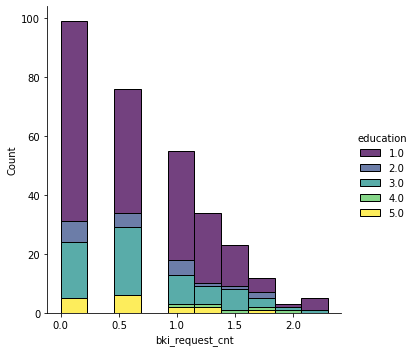

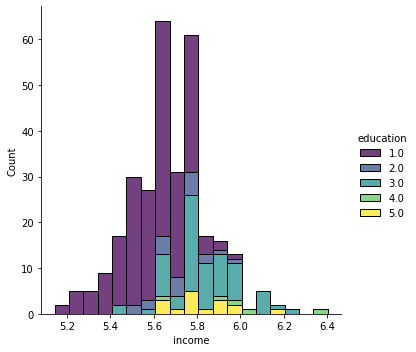

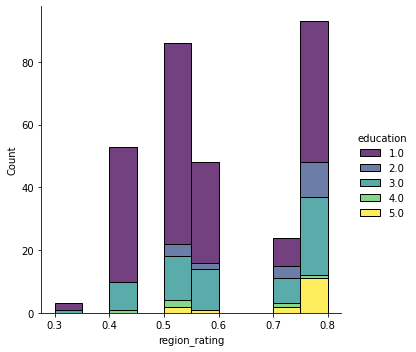

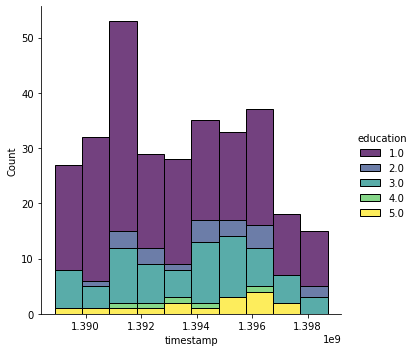

In [73]:
for col in num_cols:
    sns.displot(train[train.edu_isna == 1], x=col, hue='education', palette = 'viridis', multiple='stack')

## Вывод

Распределение предсказанных значений схожи со средними по популяции. Имеются трудности с предсказанием 2го класса (UGR), вероятно, из-за того, что 1ый и 3ий классы в выборке представлены большим кол-вом значений. Также повышено предсказание 5го класса

Вместе с тем, зависимости для предсказанных значений выглядят логичными. Так, образование выше в регионах с высоким рейтингом, для людей с более высоким доходом. Неоконченное высшее предсказано для более молодых людей.

В целом, иммет смысл оставить вспомогательную переменную 'edu_isna', чтобы была возможности разделить предсказанные и объективные значения переменной.

In [74]:
bin_cols.append('edu_isna')

# Feature Engineering

<AxesSubplot:>

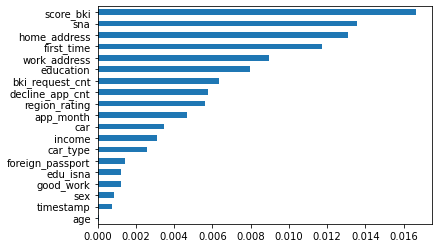

In [75]:
# Расчет взаимной иформации
features = train.copy().drop('default', axis = 1)
target = train.default
mi_scores = mi_class(features, target)
mi_scores = mi_scores.sort_values()
mi_scores.plot(kind = 'barh')

## Clusters

Unsupervised ML способен разбить данные на кластеры, для которых закономерности отличаются.

Параметры выбраны произвольно.

In [76]:
# Отбираем признаки с MI score > 0.005
cluster_cols = mi_test(features.columns, 0.005)
cluster_cols

['education',
 'decline_app_cnt',
 'score_bki',
 'bki_request_cnt',
 'region_rating',
 'home_address',
 'work_address',
 'sna',
 'first_time']

In [77]:
# Применение кластеризации
kmeans = KMeans(n_clusters=5, max_iter = 1500, n_init = 20, random_state = RC)
kmeans.fit(train[cluster_cols])
train["cluster"] = kmeans.predict(train[cluster_cols])

### Результаты

In [78]:
train.sample(5)

education  sex       age  car  car_type  decline_app_cnt  good_work  \
12731        3.0    0  3.270776    1         0                0          0   
13264        2.0    0  3.568332    0         0                0          0   
428          1.0    1  3.033470    1         1                0          0   
53093        3.0    1  3.496999    1         0                0          0   
51901        3.0    1  2.912908    0         0                0          0   

       score_bki  bki_request_cnt  region_rating  ...  work_address    income  \
12731  -2.132543         0.663986            0.5  ...             1  5.668952   
13264  -2.211751         1.026559            0.5  ...             2  5.560409   
428    -1.737605         1.026559            0.5  ...             3  5.560409   
53093  -0.806702         1.272896            0.5  ...             2  5.894097   
51901  -2.225004         0.000000            0.5  ...             3  5.598473   

       sna  first_time  foreign_passport  default  app_month   timestamp  \
12731    1           1                 0        0          4  1397174400   
13264    1           3                 0        0          4  1398384000   
428      1           4                 0        0          3  1394496000   
53093    2           3                 0        0          1  1390780800   
51901    2           3                 0        0          4  1398643200   

       edu_isna  cluster  
12731         0        0  
13264         0        1  
428           0        2  
53093         0        4  
51901         0        4  

[5 rows x 21 columns]

CLUSTER
4(%%):	25.84723370235369
	 default rate(%%):	6.977719528178243
2(%%):	21.970487404978385
	 default rate(%%):	12.705069692858023
3(%%):	20.050407187089256
	 default rate(%%):	20.348719335000336
1(%%):	19.290234285017412
	 default rate(%%):	9.742905310480472
0(%%):	12.841637420561256
	 default rate(%%):	16.703598185079667
Найдены статистически значимые различия


<Figure size 432x288 with 0 Axes>

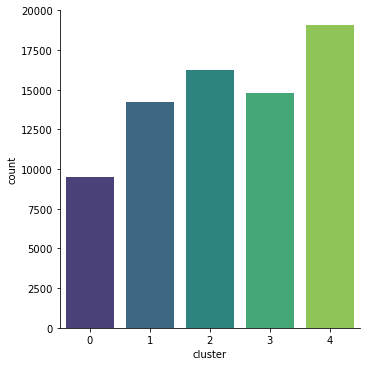

In [79]:
summary(train, 'cluster')

Имеются видимые различия между кластерами. Вместе с тем, признак не линейен отностительно 'default'.

In [80]:
cat_cols.append('cluster')

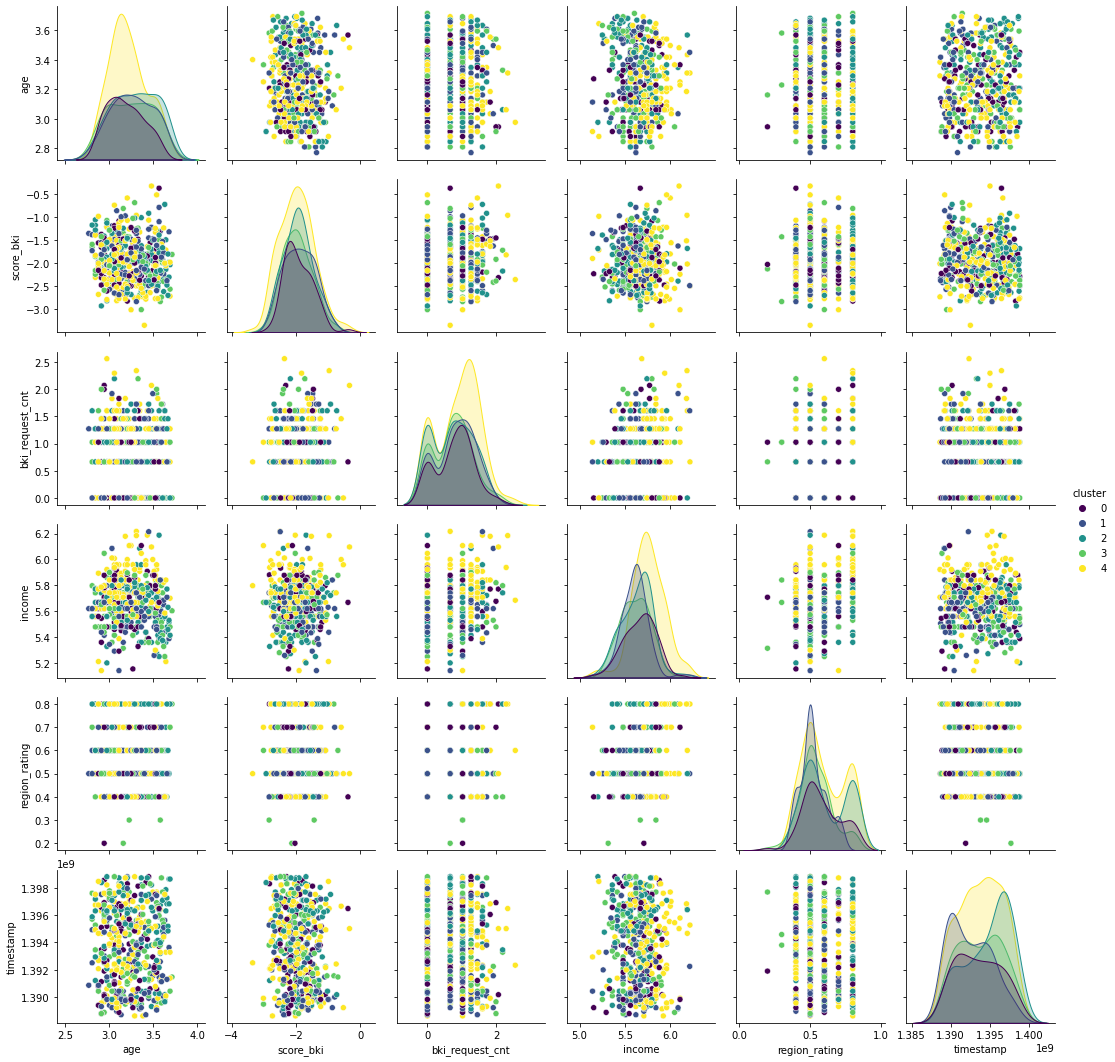

In [81]:
sns.pairplot(train[num_cols+['cluster']].sample(500, random_state = RC), hue = 'cluster', palette = 'viridis')

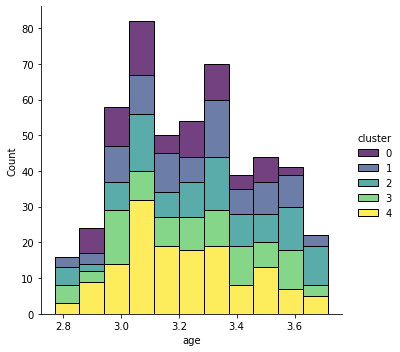

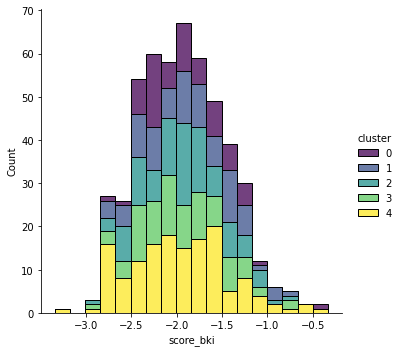

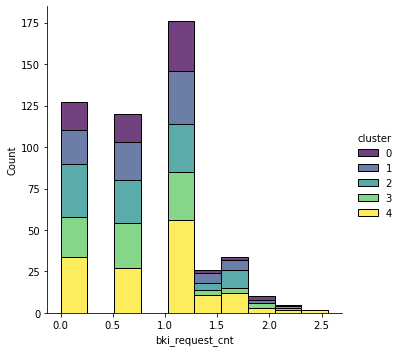

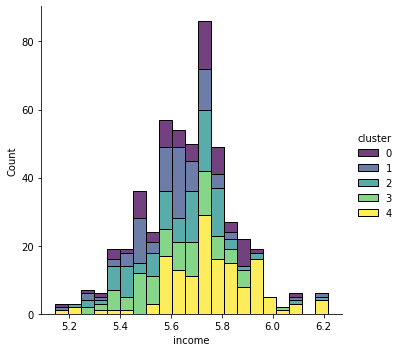

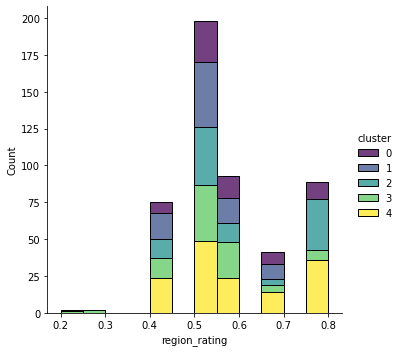

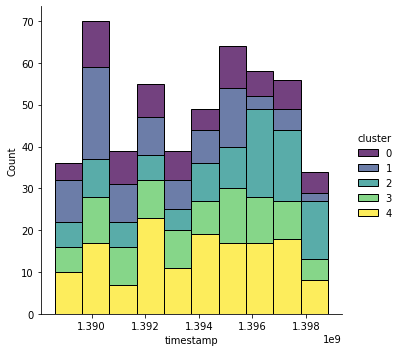

In [82]:
for col in num_cols:
    sns.displot(train.sample(500, random_state = RC), x=col, hue='cluster', palette = 'viridis', multiple='stack')

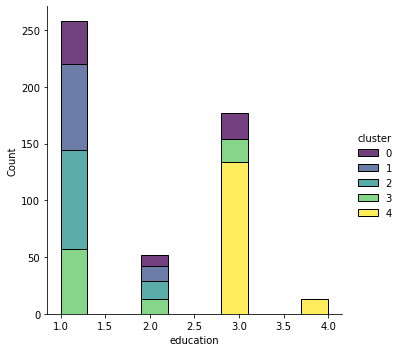

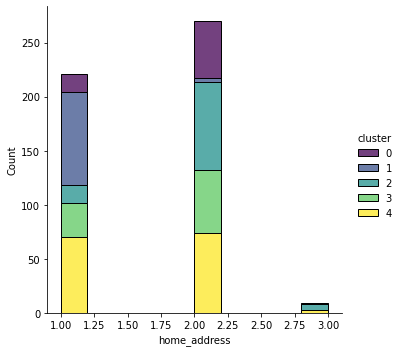

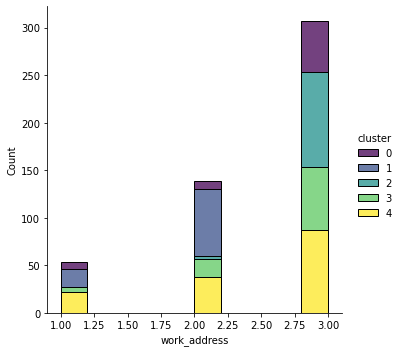

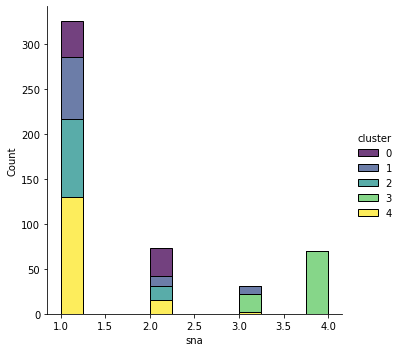

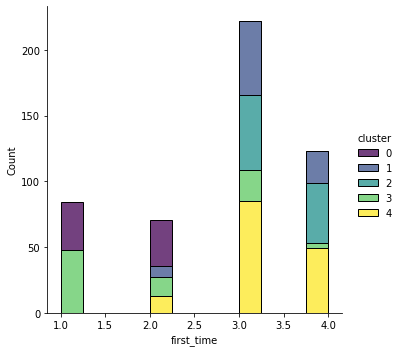

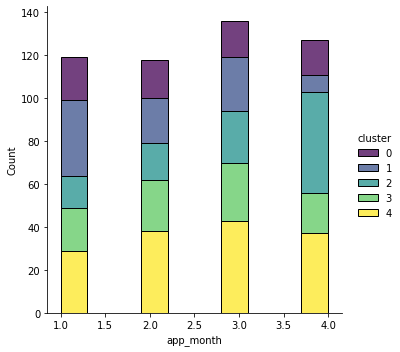

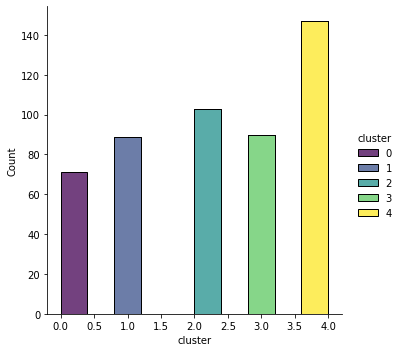

In [83]:
for col in cat_cols:
    sns.displot(train.sample(500, random_state = RC), x=col, hue='cluster', palette = 'viridis', multiple='stack')

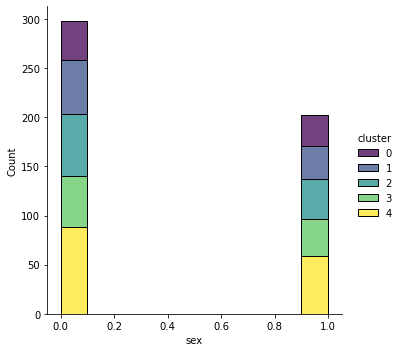

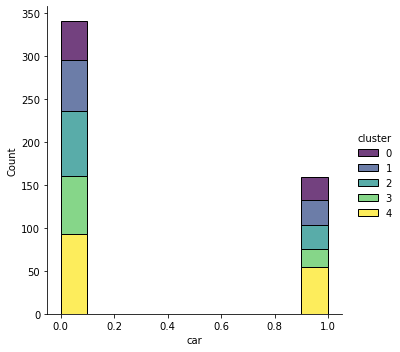

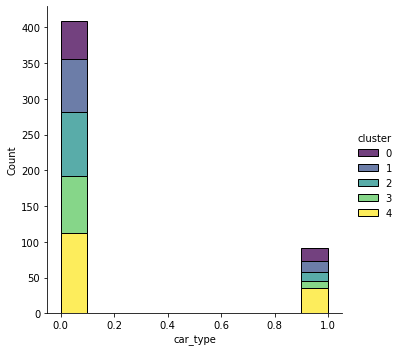

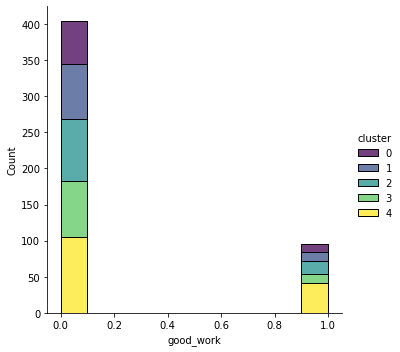

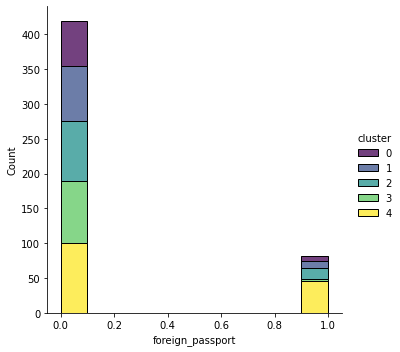

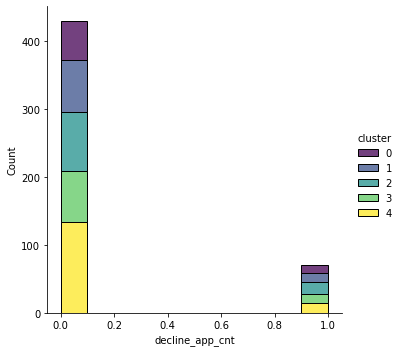

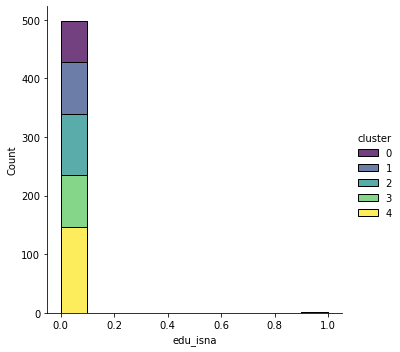

In [84]:
for col in bin_cols:
    sns.displot(train.sample(500, random_state = RC), x=col, hue='cluster', palette = 'viridis', multiple='stack')

Визуально заметно:
- В кластере 4, привалируют люди с большим доходом и относительно высоким образованием
- Для кластера 3 характерна слабая связь заемщика с клиентами банка (значения 3 и 4)
- В кластере 2, заемщики с сильной связью с клиентами банка (значения 1 и 2), высоким 'first_time', но относительно низким образованием
- В кластер 1, отличается от кластера 2 конценрацией в home_adress == 1
- В кластере 0, заемщики со средним уровнем bki_score

<AxesSubplot:>

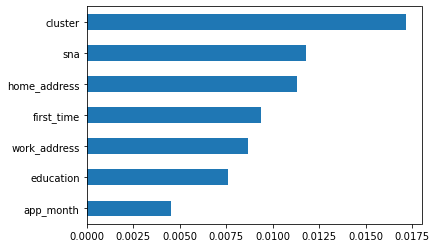

In [85]:
# Расчет взаимной иформации
features = train[cat_cols].copy()
target = train.default
mi_scores = mi_class(features, target)
mi_scores = mi_scores.sort_values()
mi_scores.plot(kind = 'barh')

Итоговая переменная 'cluter' имеет большую взаимную информацию с целевой переменной по сравнению с остальными категориальными признаками, и несет ценность для модели.

## PCA

Метод главных компанент позволяет выявить перспективные пары признаков для создания новых

In [86]:
# Стандартизация числовых переменных, выделение целевой
A = StandardScaler().fit_transform(train[num_cols].values)
b = train.default

In [87]:
# Применение метода главных компанет
pca = PCA(random_state = RC)
A_pca = pca.fit_transform(A)
component_names = [f"PC{i+1}" for i in range(A_pca.shape[1])]

A_pca = pd.DataFrame(A_pca, columns=component_names)
A_pca.head()

PC1       PC2       PC3       PC4       PC5       PC6
0  1.489047  0.080595  0.339226  1.381956  0.664542 -0.029471
1  1.097981  0.900151  1.273215  0.052216  0.828360  0.042784
2 -1.802845  0.607494 -1.409473  0.188500  0.490279  1.096231
3  1.845447  0.646443  0.108447  1.288107  0.130398  0.890167
4 -0.021199  0.129554  0.771134 -1.152885  1.615480 -0.262676

<AxesSubplot:>

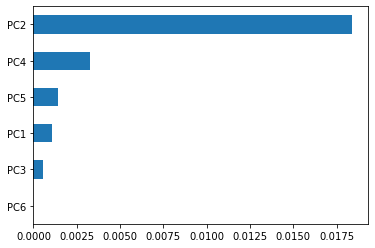

In [88]:
# Оцентка компанент
mi_scores = mutual_info_classif(A_pca, b, random_state = RC)
mi_scores = pd.Series(mi_scores, index=A_pca.columns)
mi_scores = mi_scores.sort_values()
mi_scores.plot(kind = 'barh')

Наибольшую ценность представляет компанета 'PC2'. Остальные можно спокойно отсеять, чтобы не увеличивать шум в данных.

### PC2

In [98]:
# Голова и хвост выборки, упорядоченной по 'PC2'
idx = A_pca['PC2'].sort_values(ascending=False).index
cols = num_cols

display(train.loc[idx, cols].head(10))
display(train.loc[idx, cols].tail(10))

age  score_bki  bki_request_cnt    income  region_rating  \
55405  3.060851  -0.223299         2.986413  5.708736            0.5   
33206  3.466398  -0.481892         3.043123  5.620854            0.5   
67718  3.060851  -0.702280         3.056436  5.829463            0.5   
47584  2.975565  -0.356936         2.297558  5.841720            0.5   
23064  2.975565  -0.484254         2.499029  5.560409            0.6   
35787  2.844680  -0.097323         1.727453  5.820880            0.5   
6657   2.808159  -0.348961         1.727453  5.560409            0.5   
71115  2.879550  -0.042827         1.921474  5.771906            0.6   
34067  3.496999  -0.263199         2.072081  5.460064            0.5   
14861  3.207100  -0.680085         2.499029  5.560409            0.5   

        timestamp  
55405  1391731200  
33206  1389139200  
67718  1391385600  
47584  1390003200  
23064  1390348800  
35787  1389916800  
6657   1388966400  
71115  1390694400  
34067  1390348800  
14861  1389484800

age  score_bki  bki_request_cnt    income  region_rating  \
16158  3.466398  -2.983168              0.0  5.685706            0.8   
67954  3.645626  -3.079144              0.0  5.742558            0.8   
39648  3.310398  -3.138558              0.0  5.908964            0.8   
12846  3.383819  -3.088781              0.0  6.024986            0.8   
7819   3.657744  -3.174842              0.0  5.713074            0.7   
61365  3.450606  -2.959679              0.0  6.016880            0.8   
34405  3.401091  -3.145981              0.0  5.797779            0.8   
13195  3.450606  -3.339817              0.0  5.878065            0.7   
61176  3.348017  -3.420154              0.0  5.609927            0.8   
34773  3.366134  -3.624586              0.0  5.841720            0.8   

        timestamp  
16158  1398643200  
67954  1396483200  
39648  1396224000  
12846  1395964800  
7819   1397433600  
61365  1397779200  
34405  1397952000  
13195  1396742400  
61176  1397088000  
34773  1398643200

Как видно из выборки упорядоченной по 'PC2', компанента основана на 'score_bki' и 'bki_request_cnt'.

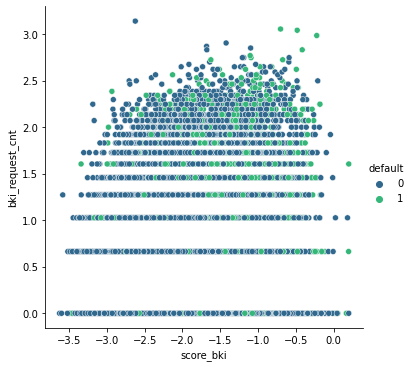

In [99]:
sns.relplot(data=train, x='score_bki', y='bki_request_cnt', hue='default', palette = 'viridis')

<AxesSubplot:ylabel='score_bki'>

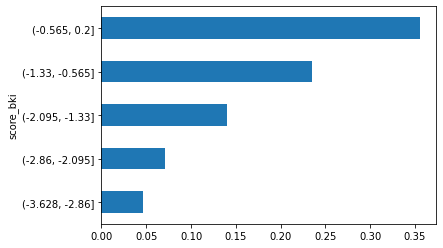

In [100]:
# Риск дефолта для категорий 'score_bki'
bins = pd.cut(train['score_bki'], bins=5)
train.groupby(bins).default.mean().plot(kind = 'barh')

<AxesSubplot:ylabel='bki_request_cnt'>

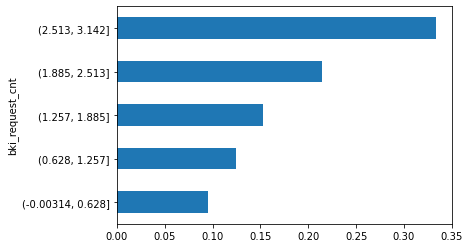

In [101]:
# Риск дефолта для категорий 'bki_request_cnt'
bins = pd.cut(train['bki_request_cnt'], bins=5)
train.groupby(bins).default.mean().plot(kind = 'barh')

Визуально, большее кол-во дефолтов характерно для клиентов с 'score_bki' близким к 0, и высоким 'bki_request_cnt'. Таким образом, новая переменная 'bki_ovrl' должна расти вместе с имеющимися.

Для этого, для 'score_bki' имеет смысл сместить минимум в 0. После чего полученный рейтинг будет помножен на 'bki_request_cnt'. Таким образом, макимальное значение 'bki_ovrl' достигается при большом количестве запросов в БКИ и плохом, с точки зрения риска дефоолта, рейтинге. Иными словами, метрика отбражает подтвержденный (многими запросами) плохой рейтинг заемщика.
(Расчет метрики через sin/cos 45 дает худший результат).

In [102]:
# Создание переменной
train['bki_ovrl'] = (train.score_bki - train.score_bki.min())*train.bki_request_cnt.values
num_cols.append('bki_ovrl')

<AxesSubplot:>

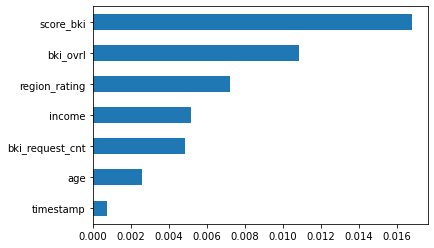

In [103]:
# Расчет взаимной иформации
features = train[num_cols].copy()
target = train.default
mi_scores = mi_class(features, target)
mi_scores = mi_scores.sort_values()
mi_scores.plot(kind = 'barh')

'bki_ovrl' показывает себя более полезной переменной, чем 'bki_request_cnt', но уступает 'score_bki'.

<AxesSubplot:ylabel='bki_ovrl'>

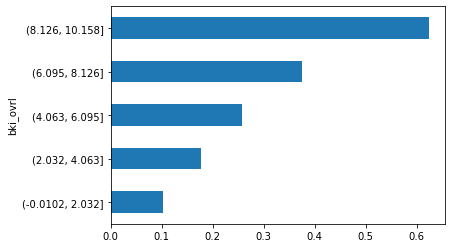

In [104]:
# Риск дефолта для категорий 'bki_ovrl'
bins = pd.cut(train['bki_ovrl'], bins=5)
train.groupby(bins).default.mean().plot(kind = 'barh')

Распределение риска дефолта ожидаемо сохраняется

<AxesSubplot:>

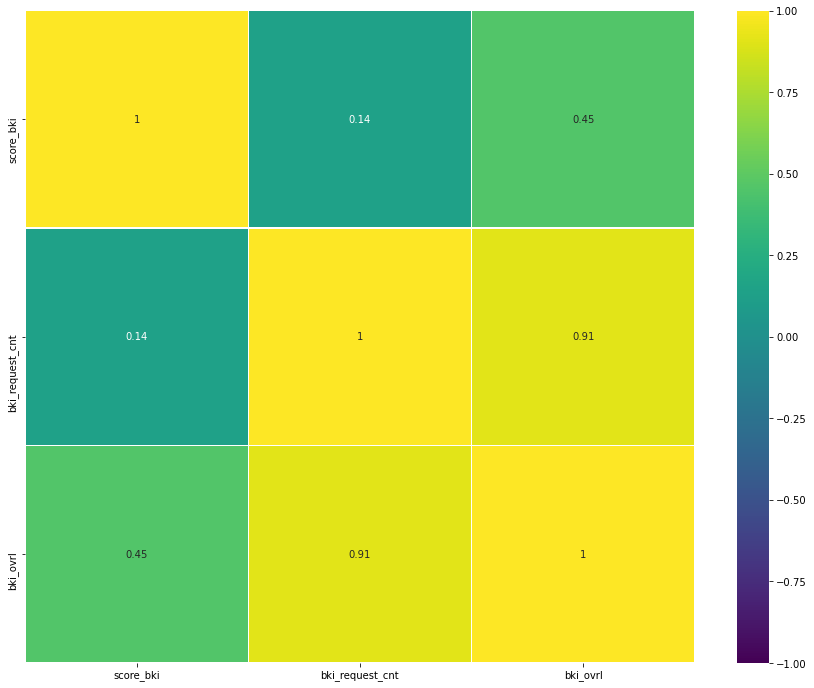

In [105]:
# Корреляционная матрица
f,ax = plt.subplots(figsize=(15, 12))
sns.heatmap(train[['score_bki','bki_request_cnt','bki_ovrl']].corr(), vmin=-1, vmax=1, annot=True, linewidths=.5, cmap='viridis')

Корреляция между 'bki_ovrl' и 'bki_score' не привышает 0.5, в то время как корреляция с 'bki_request_cnt' слишком высока. Так как 'bki_ovrl' обладает большей общей информацией с 'default', 'bki_request_cnt' будет удален.

In [106]:
train.drop('bki_request_cnt', axis = 1, inplace = True)
num_cols.remove('bki_request_cnt')

## Создание переменных на основе логики

### reliable_cust

Переменная на основе давности наличия информации о заемщике ('first_time') и связи заемщика с клиентами банка ('sna')

FIRST_TIME
3(%%):	42.35152237835201
	 default rate(%%):	12.026875699888018
4(%%):	25.389232916435184
	 default rate(%%):	8.203020761061003
1(%%):	16.58423555874741
	 default rate(%%):	18.612631750960045
2(%%):	15.6750091464654
	 default rate(%%):	15.542876901798063
Найдены статистически значимые различия


<Figure size 432x288 with 0 Axes>

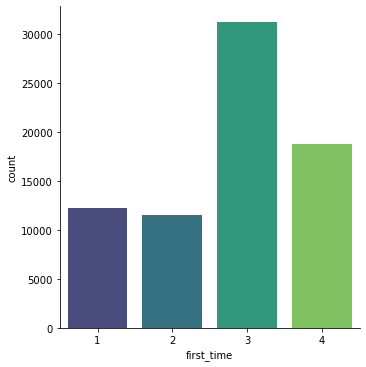

SNA
1(%%):	64.09436442228214
	 default rate(%%):	9.820088370224731
4(%%):	15.920269922356672
	 default rate(%%):	21.15073623287088
2(%%):	14.398569086301983
	 default rate(%%):	14.982119329945418
3(%%):	5.586796569059201
	 default rate(%%):	15.765219500363814
Найдены статистически значимые различия


<Figure size 432x288 with 0 Axes>

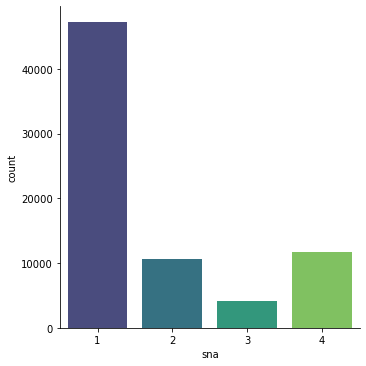

In [107]:
for col in ['first_time','sna']:
    summary(train, col)

default rate уменьшается для 'first time' и увеличивается для 'sna'

In [108]:
# Создание переменной
train['reliable_cust'] = train.first_time - train.sna

RELIABLE_CUST
2(%%):	31.627799834686105
	 default rate(%%):	10.029561715436357
3(%%):	22.833642732286346
	 default rate(%%):	7.435760488991751
1(%%):	14.700741202455317
	 default rate(%%):	13.770854456631948
0(%%):	10.032656269055137
	 default rate(%%):	16.166936790923824
-3(%%):	9.491998536565536
	 default rate(%%):	19.82869379014989
-1(%%):	7.857830051897722
	 default rate(%%):	20.831177789274015
-2(%%):	3.4553313730538355
	 default rate(%%):	19.215686274509807
Найдены статистически значимые различия


<Figure size 432x288 with 0 Axes>

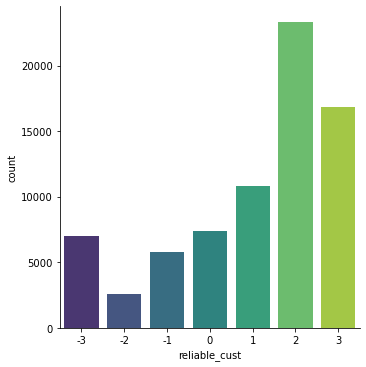

In [109]:
summary(train, 'reliable_cust')

<AxesSubplot:>

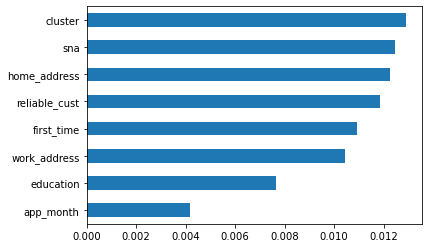

In [110]:
# Расчет взаимной иформации
features = train[cat_cols+['reliable_cust']].copy()
target = train.default
mi_scores = mi_class(features, target)
mi_scores = mi_scores.sort_values()
mi_scores.plot(kind = 'barh')

Переменная 'reliable_cust' показывает MI score выше 0.01.

In [111]:
cat_cols.append('reliable_cust')

### travel_time

Переменная на основе домашнего адреса ('home_address') и адреса работы ('work_address'). Нет ясности как закодирован признак. Для дальнейшей работы, будем считать, что оба признака обозначают зоны удалености от определенной зоны (к примеру, центр города). В таком случае, разница по модулю между 'home_address' и 'work_address' обозначает частые перемещения между зонами.

In [112]:
# Создание переменной
train['travel_time'] = train.home_address - train.work_address
train['travel_time'] = train.travel_time.apply(lambda x: -x if x<0 else x)

TRAVEL_TIME
1(%%):	79.10405290044581
	 default rate(%%):	13.798006098187674
0(%%):	13.871461672922397
	 default rate(%%):	8.459509621959558
2(%%):	7.024485426631798
	 default rate(%%):	8.699845679012345
Найдены статистически значимые различия


<Figure size 432x288 with 0 Axes>

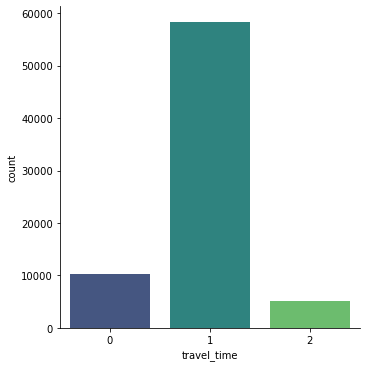

In [113]:
summary(train, 'travel_time')

<AxesSubplot:>

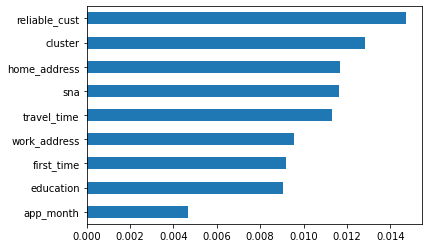

In [114]:
# Расчет взаимной иформации
features = train[cat_cols+['travel_time']].copy()
target = train.default
mi_scores = mi_class(features, target)
mi_scores = mi_scores.sort_values()
mi_scores.plot(kind = 'barh')

Переменная 'travel_time' показывает MI score выше 0.01.

In [115]:
cat_cols.append('travel_time')

### income_to_expenses

Переменная на основе дохода заемщика ('first_time') поделенная на кол-во потенциальных иточников трат на авто и заграничные поездки ('car', 'car_type', 'foreign_passport').

In [116]:
# Создание переменной
train['income_to_expenses'] = train.income/(1+train.car+train.car_type+train.foreign_passport)

INCOME_TO_EXPENSES
mean    4.272747
std     1.658575
min     1.285695
25%     2.780204
50%     5.479840
75%     5.661892
max     6.402578
Name: income_to_expenses, dtype: float64
Кол-во выбросов: 0 	 (%%: 0.0)



<Figure size 432x288 with 0 Axes>

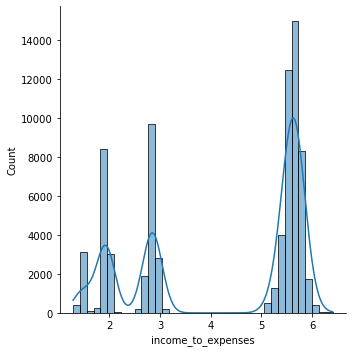

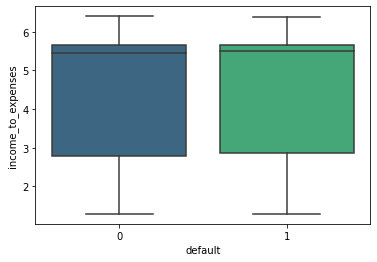

In [117]:
sum_up(train, 'income_to_expenses')

<AxesSubplot:>

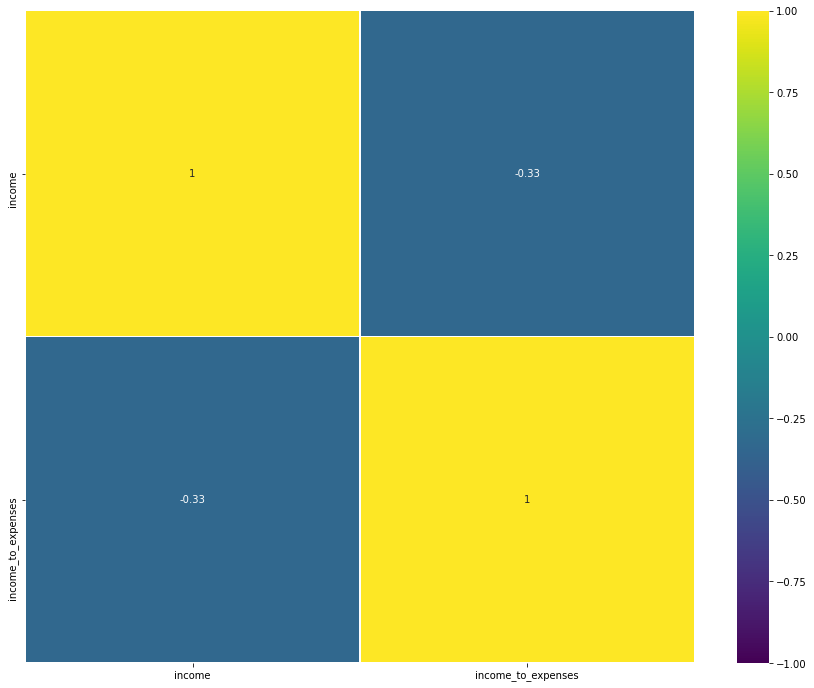

In [118]:
# Корреляционная матрица
f,ax = plt.subplots(figsize=(15, 12))
sns.heatmap(train[['income','income_to_expenses']].corr(), vmin=-1, vmax=1, annot=True, linewidths=.5, cmap='viridis')

<AxesSubplot:>

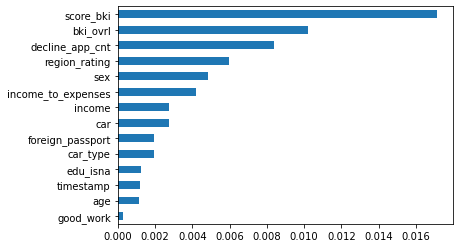

In [119]:
# Расчет взаимной иформации
features = train[bin_cols+num_cols+['income_to_expenses']].copy()
target = train.default
mi_scores = mi_class(features, target)
mi_scores = mi_scores.sort_values()
mi_scores.plot(kind = 'barh')

Переменная 'income_to_expenses' показывает более высокий MI score. Корреляция с 'income' в пределах нормы.

In [120]:
num_cols.append('income_to_expenses')

### relative_edu

Переменная на основе уровня образования ('education') и возраста ('age') заемщика, и отображает относительный уровень образования

In [121]:
# Создание переменной
train['relative_edu'] = train.education/train.age

RELATIVE_EDU
mean    0.570557
std     0.303964
min     0.266809
25%     0.302078
50%     0.347277
75%     0.891230
max     1.805165
Name: relative_edu, dtype: float64
Кол-во выбросов: 1 	 (%%: 0.001355031911001504)



<Figure size 432x288 with 0 Axes>

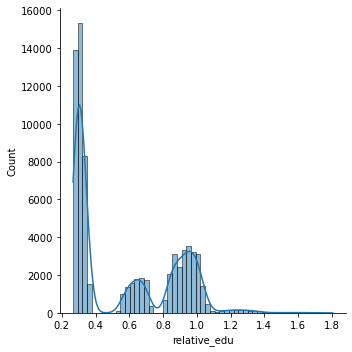

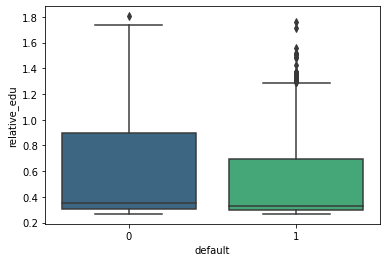

In [122]:
sum_up(train, 'relative_edu')

In [123]:
train['relative_edu'] = stats.boxcox(train['relative_edu'])[0]

RELATIVE_EDU
mean   -0.980210
std     0.774607
min    -1.963105
25%    -1.710336
50%    -1.446792
75%    -0.118978
max     0.502276
Name: relative_edu, dtype: float64
Кол-во выбросов: 0 	 (%%: 0.0)



<Figure size 432x288 with 0 Axes>

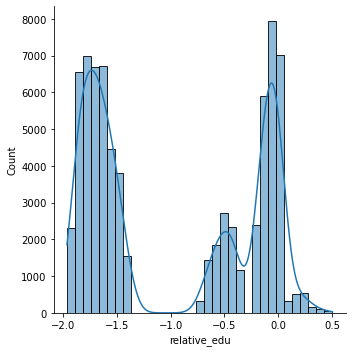

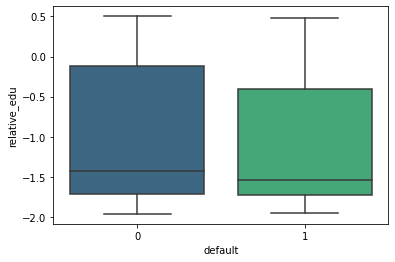

In [124]:
sum_up(train, 'relative_edu')

<AxesSubplot:>

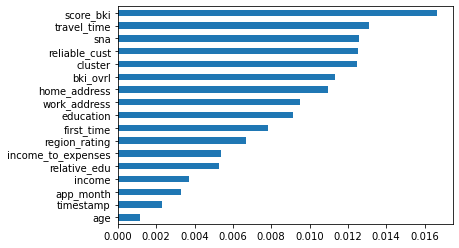

In [125]:
# Расчет взаимной иформации
features = train[cat_cols+num_cols+['relative_edu']].copy()
target = train.default
mi_scores = mi_class(features, target)
mi_scores = mi_scores.sort_values()
mi_scores.plot(kind = 'barh')

<AxesSubplot:>

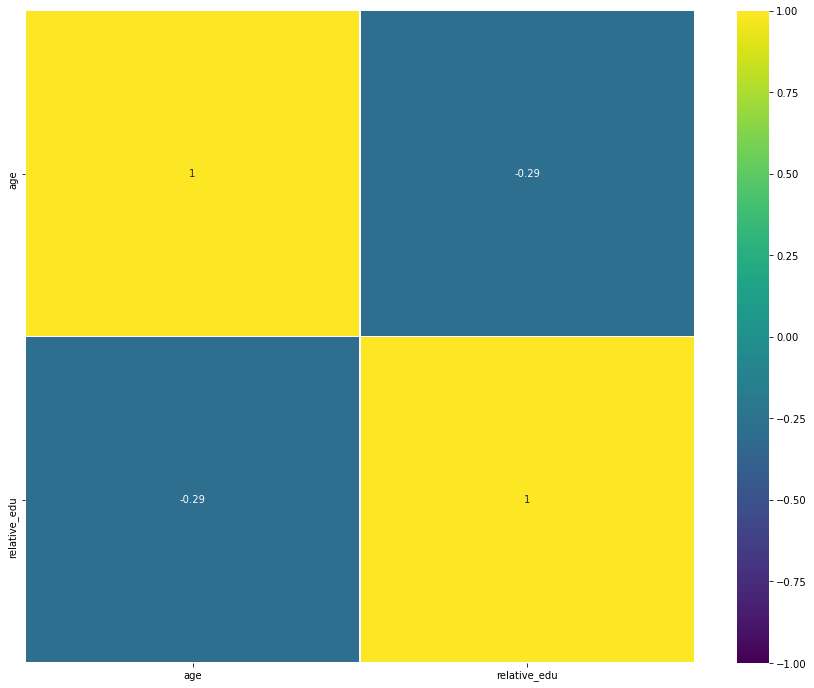

In [126]:
# Корреляционная матрица
f,ax = plt.subplots(figsize=(15, 12))
sns.heatmap(train[['age','relative_edu']].corr(), vmin=-1, vmax=1, annot=True, linewidths=.5, cmap='viridis')

'relative_edu' не дает прибавки в общей информации по сравнению с 'education', MI score ниже 0.01. Переменная может быть удалена.

In [127]:
train.drop('relative_edu', axis = 1, inplace = True)

## Создание агрегированных переменных путем перекодировки

### bin_cat_rating

Рейтинг на основе бинарных и категориальных переменных. За основу взята линейная зависимость между значениями признака и default rate. Из суммы переменных с положинельной линейной зависимостью вычетаются переменные с отрицательной линейной зависимостью. Категория 'home_address' не включена, т. к. в этом случае линейная зависимость отсутствует.

In [128]:
# Создание переменной
train['bin_cat_rating'] = train[['car', 'car_type', 'good_work', 'foreign_passport',
                                 'education', 'first_time', 'app_month']].sum(axis=1) - train[['sex', 'decline_app_cnt', 
                                                                                               'work_address', 'sna']].sum(axis=1)

In [129]:
# Необязательный сдвиг переменной, чтобы рейтинг был от 1го до 20ти
train['bin_cat_rating'] = train['bin_cat_rating'] + 7

BIN_CAT_RATING
mean    10.126045
std      3.031117
min      1.000000
25%      8.000000
50%     10.000000
75%     12.000000
max     20.000000
Name: bin_cat_rating, dtype: float64
Кол-во выбросов: 91 	 (%%: 0.12330790390113688)



<Figure size 432x288 with 0 Axes>

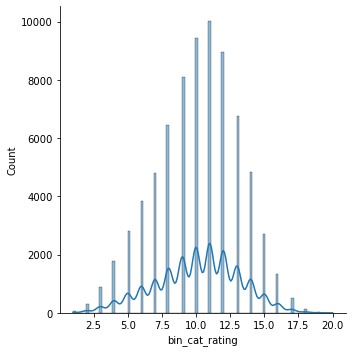

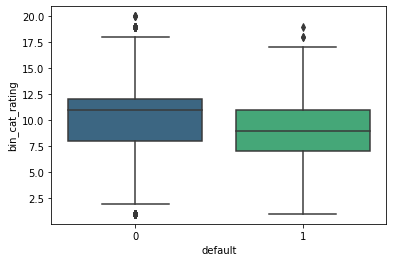

In [130]:
sum_up(train, 'bin_cat_rating')

<AxesSubplot:>

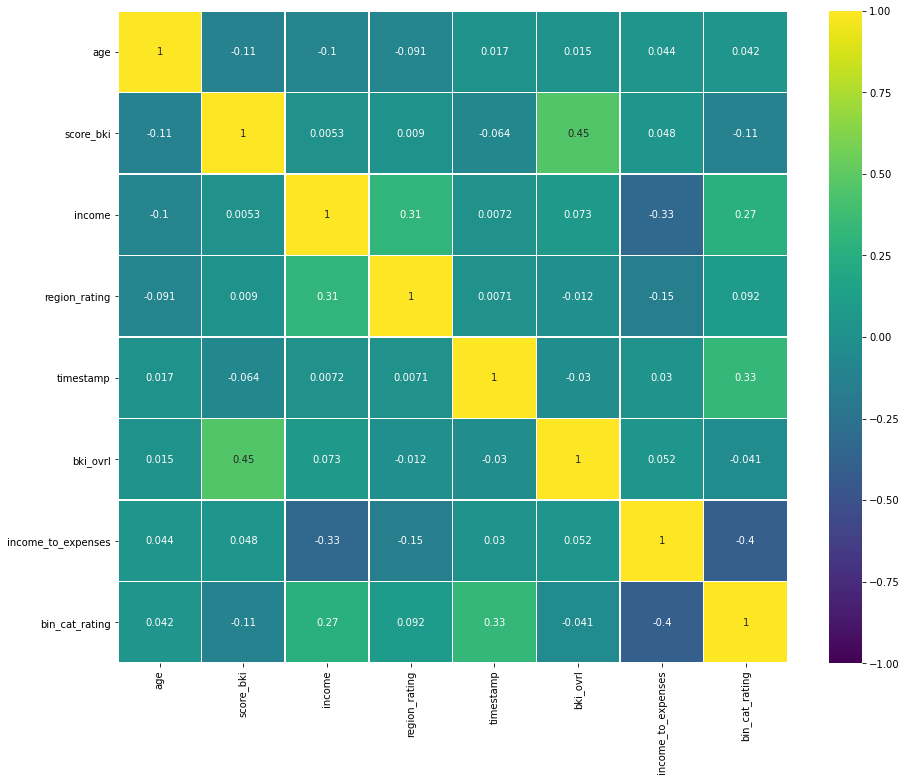

In [131]:
# Корреляционная матрица
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(train[num_cols+['bin_cat_rating']].corr(), vmin=-1, vmax=1, annot=True, linewidths=.5, cmap='viridis')

<AxesSubplot:>

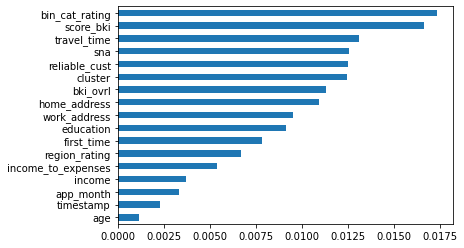

In [132]:
# Расчет взаимной иформации
features = train[cat_cols+num_cols+['bin_cat_rating']].copy()
target = train.default
mi_scores = mi_class(features, target)
mi_scores = mi_scores.sort_values()
mi_scores.plot(kind = 'barh')

Переменная 'bin_cat_rating' показывает  относительно высокий MI score. При этом, корреляция со 'score_bki' (вторым по полезности признаком) низкая. Распределение переменной нормально. Имеется незначительное кол-во выбросов.

In [133]:
num_cols.append('bin_cat_rating')

### num_category

Переменная на основе числовых данных (age','income','region_rating','score_bki'). За основу взята разница в средних значениях для дефолтных и недефолтных клиентов. Каждое значение сравнивается с медианой признака. Если значение попадает в половину с более низким default rate, клиент повышается в классе.

In [134]:
# Вспомогательный справочник для быстродействия num_transform
nt_help = pd.Series([1.0,1.0,1.0,1.0], index = ['age','income','region_rating','score_bki'], name = 'Medians')
for i in nt_help.index:
    nt_help.loc[i] = train[i].median()
nt_help

age              3.228933
income           5.668952
region_rating    0.500000
score_bki       -1.920823
Name: Medians, dtype: float64

In [135]:
# Функция возвращает значение 'num_category' для строки
def num_transform(raw):
    count = 0
    for col in ['age','income','region_rating']:
        if raw[col] > nt_help[col]:
            count += 1
    if raw['score_bki'] < nt_help['score_bki']:
        count += 1
    return count

In [136]:
# Создание переменной
train['num_category'] = train.apply(num_transform, axis = 1)

NUM_CATEGORY
2(%%):	35.69560563151262
	 default rate(%%):	11.661541965607562
1(%%):	26.671093104242605
	 default rate(%%):	16.968957984047147
3(%%):	22.46778411631594
	 default rate(%%):	7.906640130269587
0(%%):	8.771121559912736
	 default rate(%%):	21.70554611463
4(%%):	6.394395588016098
	 default rate(%%):	5.170586988768807
Найдены статистически значимые различия


<Figure size 432x288 with 0 Axes>

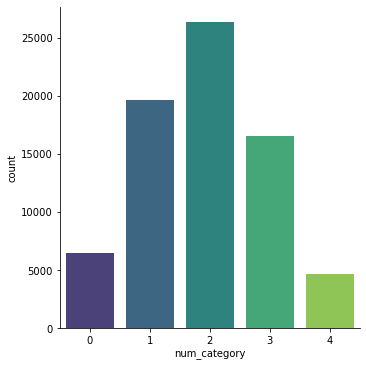

In [137]:
summary(train, 'num_category')

<AxesSubplot:>

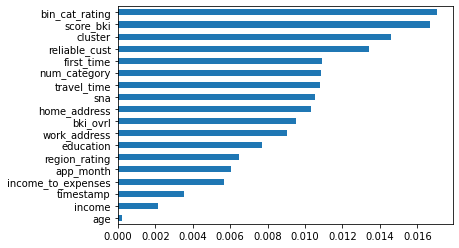

In [138]:
# Расчет взаимной иформации
features = train[cat_cols+num_cols+['num_category']].copy()
target = train.default
mi_scores = mi_class(features, target)
mi_scores = mi_scores.sort_values()
mi_scores.plot(kind = 'barh')

Переменная 'num_category' показывает MI score выше 0.01.

In [139]:
cat_cols.append('num_category')

## Итог

Не смотря на то, что созданные переменные показывают относительно высокий MI score, на тестовой выборке нет заметного улучшения метрик модели. Тем не менее, на валидационной выборке (Kaggle), есть итоговое улучшение ROC AUC

<AxesSubplot:>

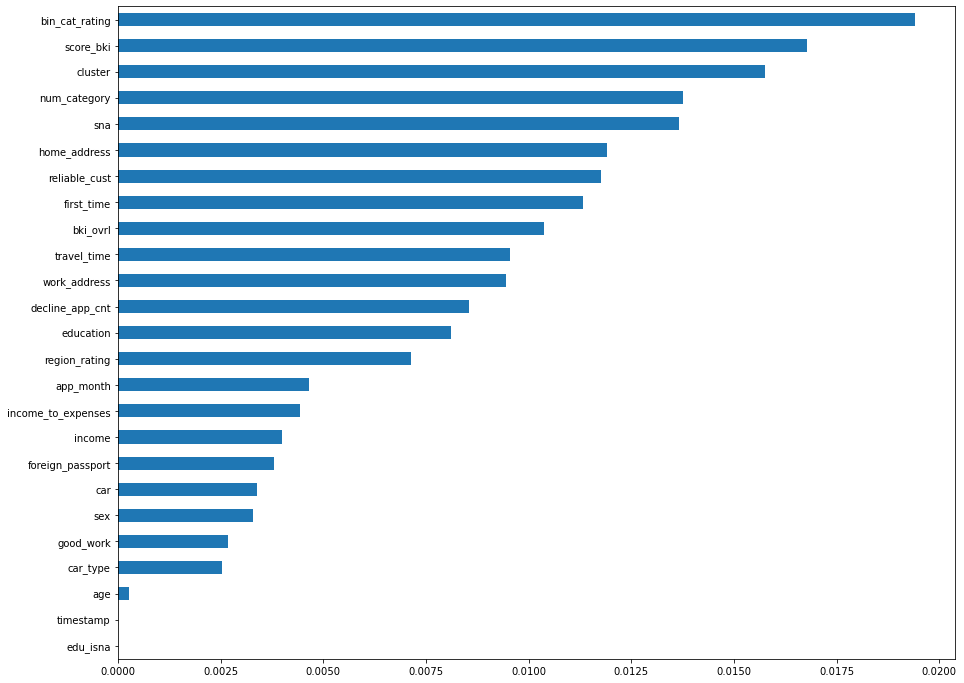

In [140]:
# Расчет взаимной иформации
features = train[cat_cols+num_cols+bin_cols].copy()
target = train.default
mi_scores = mi_class(features, target)
mi_scores = mi_scores.sort_values()
mi_scores.plot(kind = 'barh', figsize=(15, 12))

In [141]:
train.sample(5)

education  sex       age  car  car_type  decline_app_cnt  good_work  \
38725        1.0    0  3.620765    0         0                0          0   
69275        1.0    1  2.944877    0         0                0          0   
53239        3.0    1  3.005067    1         1                0          0   
25774        1.0    1  3.112813    1         0                0          0   
52464        1.0    0  3.310398    0         0                1          0   

       score_bki  region_rating  home_address  ...  app_month   timestamp  \
38725  -1.693204            0.5             2  ...          3  1393977600   
69275  -2.017252            0.4             1  ...          3  1394755200   
53239  -2.384352            0.8             2  ...          1  1390521600   
25774  -1.521864            0.8             2  ...          2  1392249600   
52464  -2.242775            0.6             1  ...          2  1391990400   

       edu_isna  cluster  bki_ovrl  reliable_cust  travel_time  \
38725         0        0  0.000000              0            1   
69275         0        1  1.067247              2            0   
53239         0        4  0.000000              3            1   
25774         0        2  0.000000              3            1   
52464         0        1  0.917503              0            1   

       income_to_expenses  bin_cat_rating  num_category  
38725            5.217753             8.0             1  
69275            5.620854            11.0             1  
53239            1.499889            13.0             3  
25774            2.854368            10.0             2  
52464            5.620854             7.0             3  

[5 rows x 26 columns]

# Model

In [142]:
# Создание предобработок данных
main_OHE = OneHotEncoder(sparse = False).fit(train[cat_cols].values)
main_SS = StandardScaler().fit(train[num_cols].values)

In [143]:
# Предобработка
X_cat = main_OHE.transform(train[cat_cols].values)
X_num = main_SS.transform(train[num_cols].values)
X = np.hstack([X_num, train[bin_cols].values, X_cat])
Y = train['default'].values

In [144]:
# Разбиение на тренировочную и тестовую выборки
X_train, X_add, y_train, y_add = train_test_split(X, Y, test_size=0.20, random_state = RC)
X_test, X_tune, y_test, y_tune = train_test_split(X_add, y_add, test_size=0.20, random_state = RC)

In [145]:
# Создание модели
model = LogisticRegression(random_state = RC)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

### ROC AUC
Площадь под кривой. Метрика отбражает вероятность предсказать правильное значение (y), относительно ошибки (x). Теоретический максимум = 1, значение рандома = 0.5.

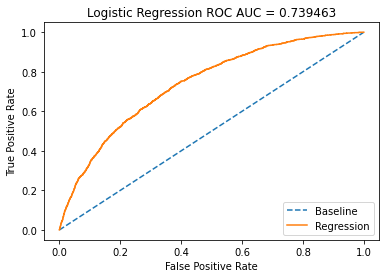

In [146]:
# Рассчет и визуализация ROC AUC
probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.6f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

### Дополнительные метрики

- Accuracy: (TN+TP)/(TP+TN+FP+FN) - отношение верно предсказанных к общему кол-ву объектов
- Precision: TP/(TP+FP) - сколько из значений, предсказаных позитивными, являются таковыми
- Recall: TP/(TP+FN) - доля из всех положительных, предсказанная верно
- F1 score: 2*Precision*Recall/(Precision+Recall) - среднее гармоническое между двумя вышеописанными метриками

Accuracy: 		 0.8743224932249323
Precision: 		 0.45054945054945056
Recall: 		 0.027796610169491524
F1 score: 		 0.052362707535121324
Confusion matrix:


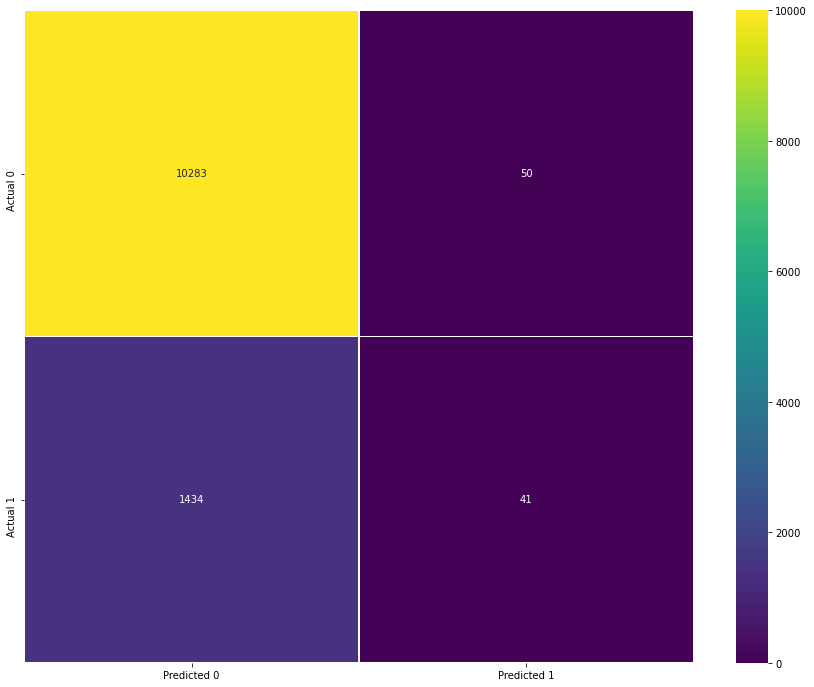

In [147]:
# Дополнительные метрики
print('Accuracy: \t\t', accuracy_score(y_test, predictions))
print('Precision: \t\t', precision_score(y_test, predictions))
print('Recall: \t\t', recall_score(y_test, predictions))
print('F1 score: \t\t', f1_score(y_test, predictions))

print('Confusion matrix:')
plt.figure(figsize=(15, 12))
matrix = pd.DataFrame(confusion_matrix(y_test, predictions), 
                      columns=[f"Predicted {i}" for i in range(0, 2)], 
                      index = [f"Actual {i}" for i in range(0, 2)])
sns.heatmap(matrix, vmin=0, vmax=10000, annot=True, linewidths=.5, cmap='viridis', fmt='d')
plt.show()

### Промежуточный вывод

Не смотря на довольно высокий ROC AUC, модель не несет практической ценности, так как крайне редко предсказывает дефолт у клиентов (2.78%% от общего числа дефолтных клиентов). Применение данной модели несет в себе недооцентку риска дефолта и может привести к убыткам.

Данный дисбаланс в предсказаниях можно исправить, устранив дисбаланс выборки

## Oversampling

In [148]:
# Функция возвращает сбалансированную выборку для бинарной переменной
def bin_oversampling(df, col):
    vc = df[col].dropna().value_counts(ascending=False)
    value = vc.max()
    parts =[]
    parts.append(df[df[col]==vc.index[0]])
    for i in range(int(vc.max()/vc.min())):
        parts.append(df[df[col]==vc.index[1]])
    parts.append(df[df[col]==vc.index[1]].head(vc.max()%vc.min()))
    sample = pd.concat(parts)
    return sample

DEFAULT
0(%%):	50.0
	 default rate(%%):	0.0
1(%%):	50.0
	 default rate(%%):	100.0
Статистически значимые различия не найдены. Данные не несут ценности.


<Figure size 432x288 with 0 Axes>

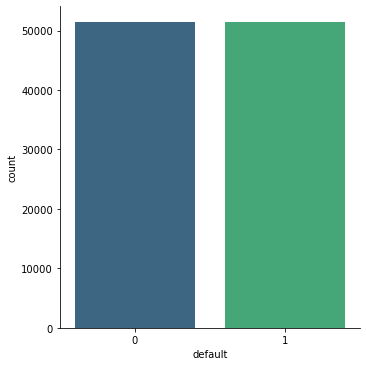

In [149]:
# Преобразование тренировочной выборки, визуализация
unbalanced = pd.DataFrame(X_train)
unbalanced['default'] = y_train
sample = bin_oversampling(unbalanced, 'default')
summary(sample, 'default')

In [150]:
# Сбалансированная обучающая выборка
blncd_X_train = sample.copy().drop('default', axis = 1).values
blncd_y_train = sample['default'].copy().values

In [151]:
# Заново обучаем модель и делаем предсказания
model = LogisticRegression(random_state = RC)
model.fit(blncd_X_train, blncd_y_train)
predictions = model.predict(X_test)

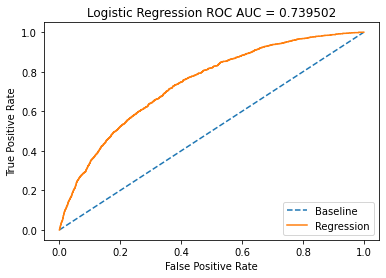

In [152]:
# Рассчет и визуализация ROC AUC
probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.6f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Accuracy: 		 0.6686991869918699
Precision: 		 0.22438362361456685
Recall: 		 0.672542372881356
F1 score: 		 0.33649932157394846
Confusion matrix:


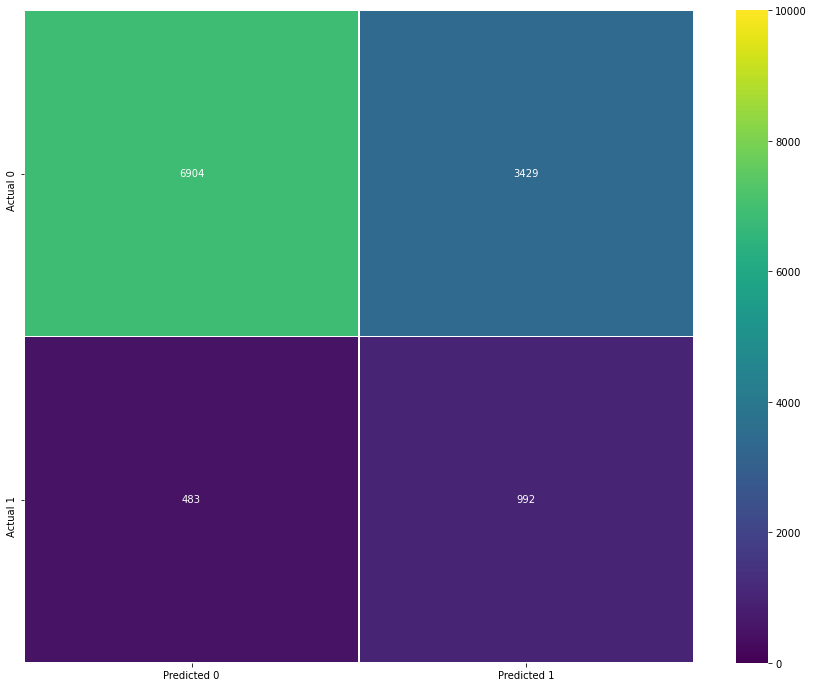

In [153]:
# Дополнительные метрики
print('Accuracy: \t\t', accuracy_score(y_test, predictions))
print('Precision: \t\t', precision_score(y_test, predictions))
print('Recall: \t\t', recall_score(y_test, predictions))
print('F1 score: \t\t', f1_score(y_test, predictions))

print('Confusion matrix:')
plt.figure(figsize=(15, 12))
matrix = pd.DataFrame(confusion_matrix(y_test, predictions), 
                      columns=[f"Predicted {i}" for i in range(0, 2)], 
                      index = [f"Actual {i}" for i in range(0, 2)])
sns.heatmap(matrix, vmin=0, vmax=10000, annot=True, linewidths=.5, cmap='viridis', fmt='d')
plt.show()

### Промежуточный вывод

После изменения обучающей выборки, целевая метрика (ROC AUC) немного увеличилась. Снизились accuracy и precision, но значительно вырос recall. Иными словами, модель усиленно ищет дефолтных клиентов:
- только 22.4% от клиентов, предсказанных как дефолтные, оказываются таковыми на самом деле.
- вместе с тем, дефолтных клиентов модель спобна предсказать в 67% случаев.

Данный консервативный подход больше подходит для внедрения модели.

(Ручная балансировка выборки дала чуть лучший recall по сравнению с гиперпараметром class_weight = 'balanced', встроенным в модель)

## Подбор гиперпараметров модели для максимизации ROC AUC

In [154]:
# Значения гиперпараметров для тестирования
C = [0.01, 0.1, 1, 10]
penalty = ['l1', 'l2']
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
warm_start = [True, False]


# Словарь гиперпараметров
hyperparameters = {'C': C, 'penalty': penalty, 
                   'solver': solver, 'warm_start':warm_start}

model = LogisticRegression(random_state = RC, max_iter=25)
model.fit(blncd_X_train, blncd_y_train)

# Создаем сетку поиска с использованием 3-кратной перекрестной проверки
gscv = GridSearchCV(model, hyperparameters, cv=3,
                   verbose=1, scoring='roc_auc')
best_model_gscv = gscv.fit(blncd_X_train, blncd_y_train)

print()
print('Лучший ROC AUC: \t', best_model_gscv.best_score_)
print()
for parameter in hyperparameters.keys():
    print('Лучший {}:\t'.format(parameter.upper()),
          best_model_gscv.best_estimator_.get_params()[parameter])

Fitting 3 folds for each of 80 candidates, totalling 240 fits

Лучший ROC AUC: 	 0.7347396136353269

Лучший C:	 1
Лучший PENALTY:	 l1
Лучший SOLVER:	 saga
Лучший WARM_START:	 True


In [155]:
# Значения гиперпараметров для тестирования
C = [0.01, 0.1, 1, 10]
penalty = ['l1', 'l2']
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
warm_start = [True, False]

# Словарь гиперпараметров
hyperparameters = {'C': C, 'penalty': penalty, 
                   'solver': solver, 'warm_start':warm_start}

model = LogisticRegression(random_state = RC, max_iter=25)
model.fit(blncd_X_train, blncd_y_train)

# Создаем случайный поиск с использованием 5-кратной перекрестной проверки
rscv = RandomizedSearchCV(model, hyperparameters, cv=5, n_iter=160,
                   verbose=1, scoring='roc_auc')
best_model_rscv = rscv.fit(blncd_X_train, blncd_y_train)

print()
print('Лучший ROC AUC: \t', best_model_rscv.best_score_)
print()
for parameter in hyperparameters.keys():
    print('Лучший {}:\t'.format(parameter.upper()),
          best_model_rscv.best_estimator_.get_params()[parameter])

Fitting 5 folds for each of 80 candidates, totalling 400 fits

Лучший ROC AUC: 	 0.7347507706950198

Лучший C:	 1
Лучший PENALTY:	 l1
Лучший SOLVER:	 saga
Лучший WARM_START:	 True


In [156]:
# Проверка: являются ли модели, подобранные двумя медтодами одинаковыми
str(best_model_gscv.best_estimator_) == str(best_model_rscv.best_estimator_)

True

In [157]:
best_model = best_model_gscv.best_estimator_

In [158]:
# Измерение точности модели, выбранной при помощи GridSearchCV, в зависимости от кол-ва итераций
start_time = time.time()
model_test = []
for n_iter in range(1, 51, 1):
    model = LogisticRegression(C=1, max_iter=n_iter, penalty='l1', random_state=RC,
                               solver='saga', warm_start=True)
    model.fit(blncd_X_train, blncd_y_train)
    probs = model.predict_proba(X_test)
    probs = probs[:, 1]
    model_test.append(roc_auc_score(y_test, probs))
    print(('Processing: {} %'.format(n_iter*2)), end="\r")
print('Веремя выполнения кода: \t{} sec.'.format((time.time() - start_time)))

Веремя выполнения кода: 	146.64641880989075 sec.


Лучший результат модели (ROC_AUC = 0.739537141985444) при параметре = Int64Index([10], dtype='int64')



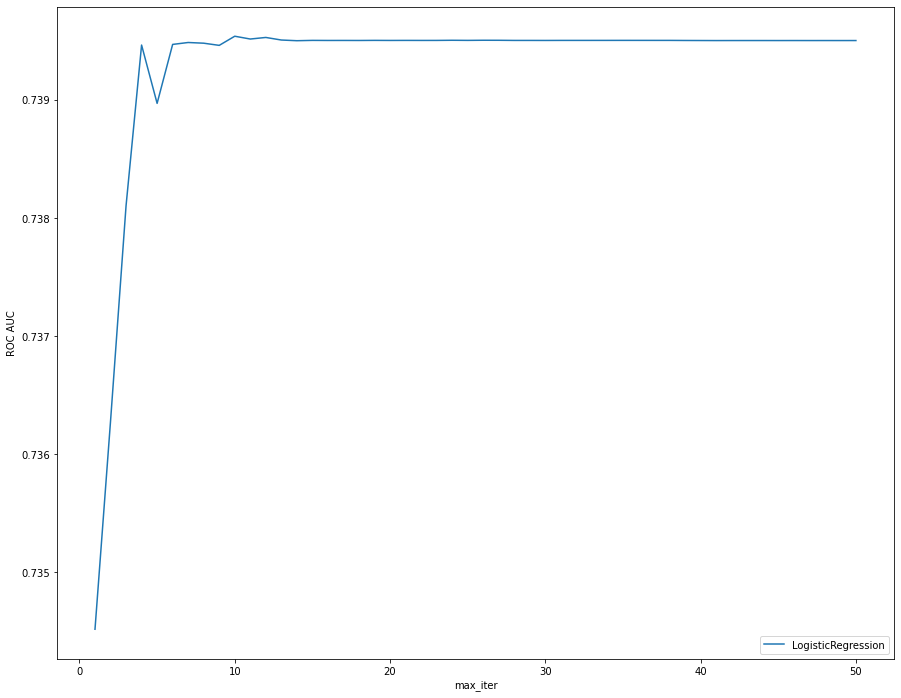

In [159]:
# Визуализация результатов
r = pd.Series(model_test, index = [x for x in range(1, 51, 1)])
print('Лучший результат модели (ROC_AUC = {}) при параметре = {}'.format(r.max(), r[r == r.max()].index))
print()

plt.figure(figsize=(15, 12))
ax = sns.lineplot(x=range(1, 51, 1), y=r, label='LogisticRegression')
ax.set(ylabel='ROC AUC', xlabel='max_iter')
plt.legend(loc='lower right')
plt.show()

К 25ти итерациям модель находится на плато. Нет необходимости менять параметр.

## Итог

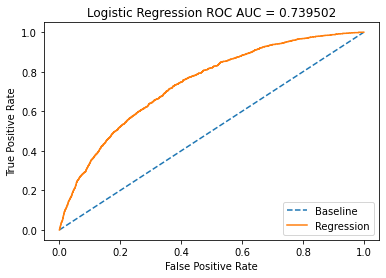

In [160]:
# Рассчет и визуализация ROC AUC
probs = best_model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.6f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Accuracy: 		 0.6688685636856369
Precision: 		 0.22448517764200046
Recall: 		 0.672542372881356
F1 score: 		 0.336613505259586
Confusion matrix:


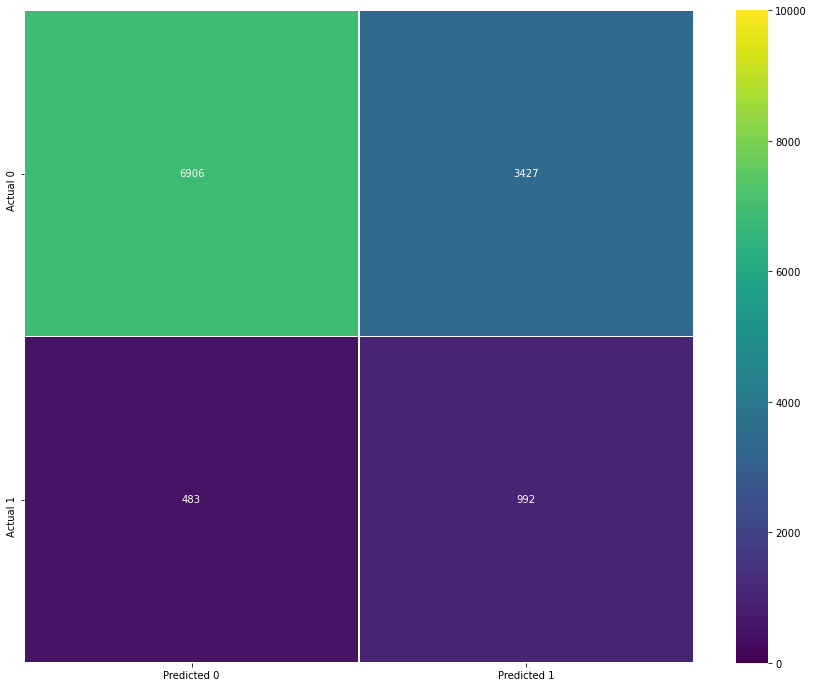

In [161]:
# Дополнительные метрики
predictions = best_model.predict(X_test)
print('Accuracy: \t\t', accuracy_score(y_test, predictions))
print('Precision: \t\t', precision_score(y_test, predictions))
print('Recall: \t\t', recall_score(y_test, predictions))
print('F1 score: \t\t', f1_score(y_test, predictions))

print('Confusion matrix:')
plt.figure(figsize=(15, 12))
matrix = pd.DataFrame(confusion_matrix(y_test, predictions), 
                      columns=[f"Predicted {i}" for i in range(0, 2)], 
                      index = [f"Actual {i}" for i in range(0, 2)])
sns.heatmap(matrix, vmin=0, vmax=10000, annot=True, linewidths=.5, cmap='viridis', fmt='d')
plt.show()

Подбор гиперпараметров существенно не улучшил модель. На тестовой выборке, модель, немного лучше предсказывает недефолтных клиентов. Для валидации, на скрытой выборке на Kaggle, будет использована:

In [162]:
best_model

LogisticRegression(C=1, max_iter=25, penalty='l1', random_state=42,
                   solver='saga', warm_start=True)

# Submission

## Data preprocessing

In [163]:
# Функция возвращает данные после предобработки
def preprocessing(df):
    
    # Удаление 'client_id'
    df.drop('client_id', axis = 1, inplace = True)
    
    # Перевод 'app_date' в формат datetime
    df.app_date = pd.to_datetime(df.app_date, infer_datetime_format=True)
    
    # Кодировка бинарных признаков
    for column in obj_cols(df, bin_cols[:-1]):
        df[column] = label_encoder.fit_transform(df[column])
    
    # Кодировка 'education'
    mapping_dict = {'SCH': 1, 'UGR': 2, 'GRD':3, 'PGR':4, 'ACD':5}
    df['education'] = df.education.map(mapping_dict)
    
    # Нормализация признаков
    for col in ['decline_app_cnt', 'bki_request_cnt']:
        df[col] = df[col].apply(lambda x: x+1)
    for col in ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']:
        df[col] = stats.boxcox(df[col])[0]
    
    # Изменение размерности 'region_rating'
    df['region_rating'] = df['region_rating']/100
    
    # Перевод 'decline_app_cnt' в категориальный признак
    df['decline_app_cnt'] = df.decline_app_cnt.apply(lambda x: 1 if x>0 else 0)
    
    # Создание 'app_month' и 'timestamp', удаление 'app_date'
    df['app_month'] = df.app_date.dt.month
    df['timestamp'] = df.app_date.values.astype(np.int64) // 10 ** 9
    df.drop('app_date', axis = 1, inplace = True)
    
    # Заполнение пропусков 'education'
    edu_na_s = df[df.education.isna() == True].drop('education', axis = 1)
    edu_na_cat = edu_OHE.transform(edu_na_s[edu_cat_cols].values)
    edu_na_num = edu_SS.transform(edu_na_s[edu_num_cols].values)
    edu_na = np.hstack([edu_na_num, edu_na_s[edu_bin_cols].values, edu_na_cat])
    edu_pred = edu_model.predict(edu_na)
    edu_pred = pd.Series(edu_model.predict(edu_na), index = edu_na_s.index)
    df['edu_isna'] = df.education.apply(isna)
    df['education'] = df.apply(lambda x: edu_pred[x.name] if x['edu_isna'] == 1 else x['education'], axis = 1)
    
    # Кластеризация
    df['cluster'] = kmeans.predict(df[cluster_cols])
    
    # Итог PCA
    df['bki_ovrl'] = (df.score_bki - df.score_bki.min())*df.bki_request_cnt.values
    df.drop('bki_request_cnt', axis = 1, inplace = True)
    
    # Переменные на основе логики
    df['reliable_cust'] = df.first_time - df.sna
    df['travel_time'] = df.home_address - df.work_address
    df['travel_time'] = df.travel_time.apply(lambda x: -x if x<0 else x)
    df['income_to_expenses'] = df.income/(1+df.car+df.car_type+df.foreign_passport)
    
    # Агрегированные переменные
    df['bin_cat_rating'] = df[['car', 'car_type', 'good_work', 'foreign_passport',
                                 'education', 'first_time', 'app_month']].sum(axis=1) - df[['sex', 'decline_app_cnt', 
                                                                                               'work_address', 'sna']].sum(axis=1)
    df['bin_cat_rating'] = df['bin_cat_rating'] + 7
    df['num_category'] = df.apply(num_transform, axis = 1)
    
    return df

In [164]:
# Загрузка данных
test = pd.read_csv('test.csv')

In [165]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [166]:
for column in test.columns:
    value = test[column].isna().sum()
    if value > 0:
        print(column.upper())
        print('%% пропущенных данных в столбце: \t{}'.format(value/len(train[column])*100))
        print('(%% от общего кол-ва данных: \t{})'.format(value/np.product(train.shape)*100))
        print()

EDUCATION
%% пропущенных данных в столбце: 	0.2317104567812572
(%% от общего кол-ва данных: 	0.00891194064543297)



In [167]:
client_id = test.client_id

In [168]:
# Создание 'default' в тестовых данных
test['default'] = 100

In [169]:
# Предобработка и результат
valid= preprocessing(test)
valid.sample(5)

education  sex       age  car  car_type  decline_app_cnt  good_work  \
27834        1.0    0  3.518391    0         0                0          0   
23942        1.0    1  3.161392    1         1                0          0   
11991        3.0    0  3.161392    0         0                0          1   
21410        3.0    1  3.350345    1         0                0          0   
22904        1.0    0  3.084306    1         0                1          1   

       score_bki  region_rating  home_address  ...  app_month   timestamp  \
27834  -1.717958            0.4             1  ...          1  1391040000   
23942  -1.895426            0.6             1  ...          2  1391731200   
11991  -2.071951            0.5             2  ...          1  1390780800   
21410  -2.457443            0.5             1  ...          2  1391472000   
22904  -1.652379            0.5             1  ...          1  1390521600   

       edu_isna  cluster  bki_ovrl  reliable_cust  travel_time  \
27834         0        1  1.898837              3            1   
23942         0        0  0.000000             -1            1   
11991         0        4  1.536721              2            1   
21410         0        4  1.415246              2            0   
22904         0        1  3.067868              3            1   

       income_to_expenses  bin_cat_rating  num_category  
27834            5.613149            10.0             1  
23942            2.041763             8.0             2  
11991            5.698778            11.0             2  
21410            3.109979            13.0             3  
22904            2.863240            11.0             1  

[5 rows x 26 columns]

In [170]:
# Проверка, что данные содержат одинаковое кол-во признаков
print(len(train.columns)-len(test.columns))

0


## Предобработка для моделирования

In [171]:
# Обработка признаков для модели
X_valid_cat = main_OHE.transform(valid[cat_cols].values)
X_valid_num = main_SS.transform(valid[num_cols].values)
X_valid = np.hstack([X_valid_num, valid[bin_cols].values, X_valid_cat])

## Применение модели

In [172]:
predictions = best_model.predict(X_valid)

probs = best_model.predict_proba(X_valid)
probs = probs[:, 1]

In [173]:
result = pd.DataFrame({'client_id': client_id, 'default': probs})

In [174]:
result

client_id   default
0          74835  0.201646
1          17527  0.768575
2          75683  0.319810
3          26883  0.415430
4          28862  0.168728
...          ...       ...
36344      83775  0.800129
36345     106254  0.093567
36346      81852  0.796072
36347       1971  0.706769
36348      69044  0.723242

[36349 rows x 2 columns]

In [175]:
result.to_csv('submission.csv', index = False)

# Результат

На валидационной выборке (Kaggle), ROC AUC = 0.73966. Это максимум, который удалось выжать из линейной классификации.

# Пробуем улучшить результат

Для этого обучим модель, которая будет принимать на вход предсказания нескольких.

## Создание альтернативных моделей

На превом этапе, необходимо добавить результаты альтернативных моделей: KNeighborsClassifier и DecisionTreeClassifier. Для быстродействия алгоритма и в силу специфики KNeighbors, модели будут обучены на undersample.

DEFAULT
0(%%):	50.0
	 default rate(%%):	0.0
1(%%):	50.0
	 default rate(%%):	100.0
Статистически значимые различия не найдены. Данные не несут ценности.


<Figure size 432x288 with 0 Axes>

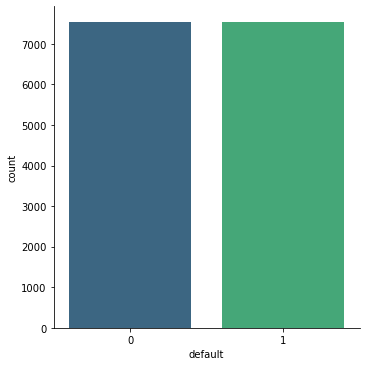

In [176]:
# Создаем undersample обучающей выборки
additional_sample = undersampling(unbalanced, 'default', min_frac = 0.5)
summary(additional_sample, 'default')

In [177]:
# Разбиваем выборку
add_X_train = additional_sample.copy().drop('default', axis = 1).values
add_y_train = additional_sample['default'].copy().values

In [178]:
# Значения гиперпараметров для тестирования KNeighborsClassifier
n_neighbors = [3, 5, 7, 10]
weights = ['uniform', 'distance']
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']

# Значения гиперпараметров для тестирования DecisionTreeClassifier
criterion = ['gini', 'entropy']
splitter = ['best', 'random']
max_depth = [3, 5, 7, 10]

# Словарь для более удобной работы с моделями в цикле
models = {'KN' : {'model' : KNeighborsClassifier(), 
                      'params': {'n_neighbors': n_neighbors,  'weights': weights, 
                                 'algorithm': algorithm}}, 
          'DT' : {'model': DecisionTreeClassifier(random_state=RC), 
                      'params': {'criterion': criterion,  'splitter': splitter, 
                                 'max_depth': max_depth}}
             }

KNeighborsClassifier()
Лучшие параметры: 		 {'algorithm': 'auto', 'n_neighbors': 10, 'weights': 'distance'}
ROC AUC: 			 0.6821739793683885


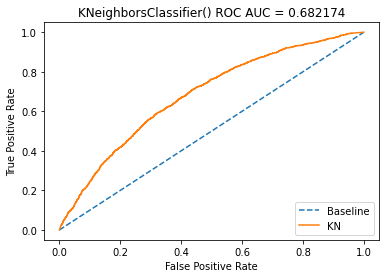

Confusion matrix:


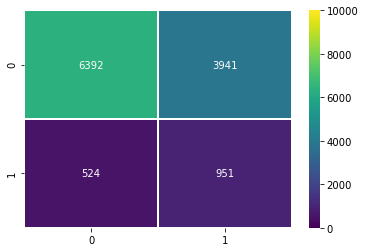

DecisionTreeClassifier(random_state=42)
Лучшие параметры: 		 {'criterion': 'gini', 'max_depth': 5, 'splitter': 'best'}
ROC AUC: 			 0.6988114761493125


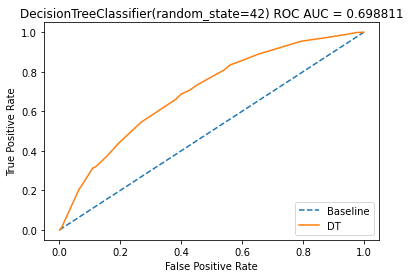

Confusion matrix:


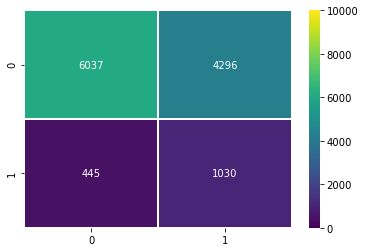

In [179]:
# Цикл поика оптимальных параметров для моделей
for k in models.keys():
    model = models[k]['model']
    hyperparameters = models[k]['params']
    print(model)
    
    # Поик оптимальных параметров для каждой модели с точки зрения ROC AUC
    gscv = GridSearchCV(model, hyperparameters, cv=5, verbose=0, 
                        scoring='roc_auc')
    search = gscv.fit(add_X_train, add_y_train)
    pred = search.best_estimator_.predict(X_test)
    probs = search.best_estimator_.predict_proba(X_test)
    probs = probs[:,1]
    
    #  Предсказание тестовой выборки моделями
    print('Лучшие параметры: \t\t', search.best_params_)

    fpr, tpr, threshold = roc_curve(y_test, probs)
    roc_auc = roc_auc_score(y_test, probs)
    print('ROC AUC: \t\t\t', roc_auc)
    
    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = k)
    plt.title('{} ROC AUC = %0.6f'.format(model) % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()
    
    print('Confusion matrix:')
    sns.heatmap(confusion_matrix(y_test, pred), vmin=0, 
                vmax=10000, annot=True, linewidths=.5, cmap='viridis', fmt='d')
    plt.show()
    
    # Добавление оптимальных моделей в словарь
    models[k]['best_model'] = search.best_estimator_

## Обработка результатов

In [180]:
# Собираем результаты в DataFrame для тестовой выборки
models_roc_auc = pd.DataFrame({'LR': best_model.predict_proba(X_test)[:, 1], 
                              'KN': models['KN']['best_model'].predict_proba(X_test)[:, 1], 
                              'DT': models['DT']['best_model'].predict_proba(X_test)[:, 1]})

In [181]:
# Добавляем для каждого клиента разброс предсказаний между моделями
models_roc_auc['spread'] = models_roc_auc.apply(lambda x: x.max()-x.min(), axis=1)

In [182]:
# Результаты альтернативных моделей пересчитываем как разницу с основной, чтобы избавиться от избыточной корреляции
for i in ['KN','DT']:
    models_roc_auc[i] = models_roc_auc.apply(lambda x: x[i]-x['LR'], axis=1)

In [184]:
# Добавляем целевую
models_roc_auc['default'] = y_test

In [185]:
models_roc_auc.sample(5)

LR        KN        DT    spread  default
4437  0.155280  0.225032  0.138515  0.225032        0
2641  0.450875 -0.166219 -0.275437  0.275437        0
4850  0.323209  0.167710  0.013348  0.167710        0
6152  0.125359 -0.021491  0.045930  0.067421        0
8959  0.305254  0.295648 -0.011459  0.307107        0

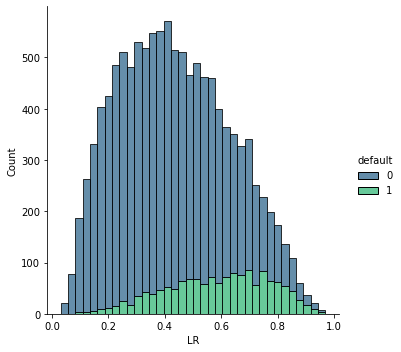

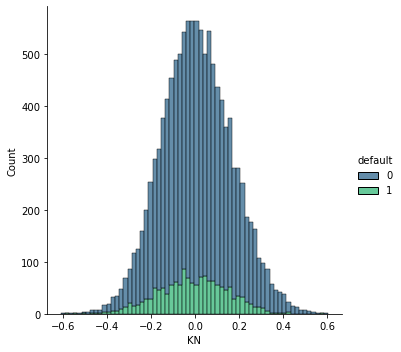

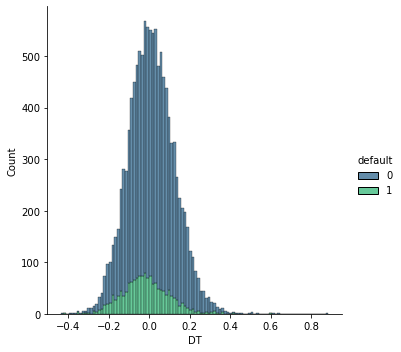

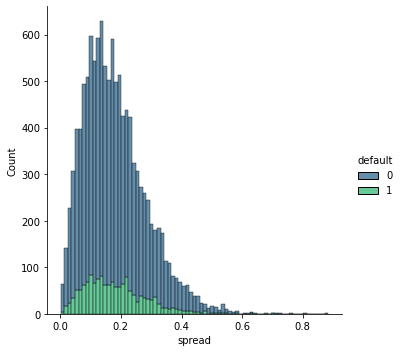

In [186]:
for col in models_roc_auc.columns[:-1]:
    sns.displot(models_roc_auc, x=col, hue='default', palette = 'viridis', multiple='stack')

Из диаграм, видно:
- С ростом вероятности дефорлта по LogisticRegression, доля дефолтных клиентов заметно увеличивается. Алгоритм работает неплохо.
- Для KNeighbors, отклонение от основной модели распределено нормально.
- Для некоторых клиентов, DecisionTree завышает вероятность дефолта. В то же время наибольшее кол-во дефолтных клиентов (пик кривой) недооценено.
- Пик разброса результатов приперно между 0.1 и 0.2.

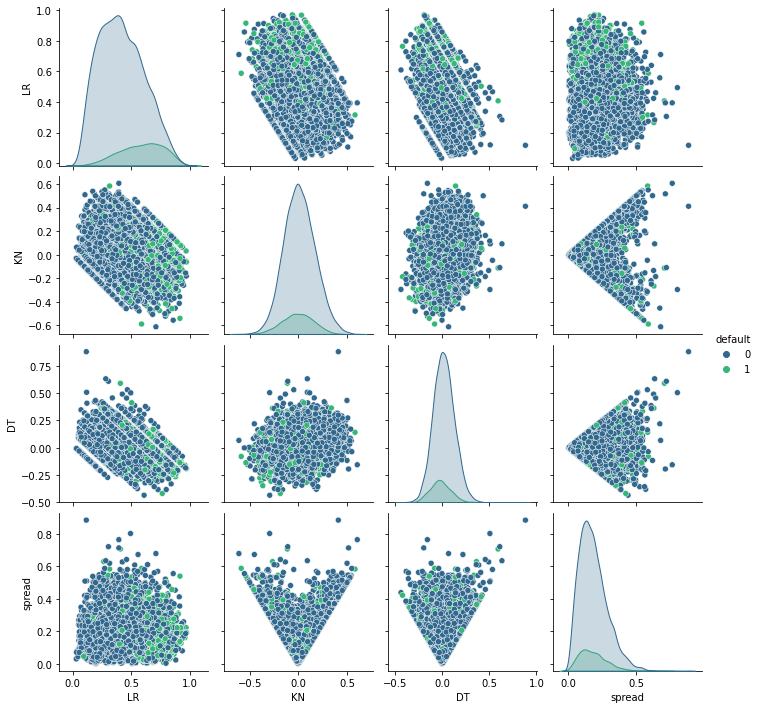

In [187]:
sns.pairplot(models_roc_auc, hue='default', palette='viridis')

Для кластеризации будем использовать предсказания LogisticRegression и разброс, т. к. линейная зависимость между ними наименее ярко выражена

In [188]:
# Применение кластеризации
kmeans_e = KMeans(n_clusters=5, max_iter = 1500, n_init = 20, random_state = RC)
kmeans_e.fit(models_roc_auc[['LR','spread']])
models_roc_auc["cluster"] = kmeans_e.predict(models_roc_auc[['LR','spread']])

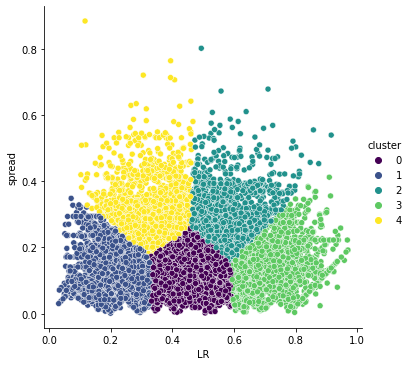

In [189]:
sns.relplot(data=models_roc_auc, x='LR', y='spread', hue='cluster', palette = 'viridis')

<AxesSubplot:>

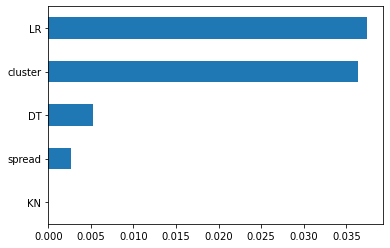

In [190]:
# Расчет взаимной иформации
features = models_roc_auc.drop('default', axis=1).copy()
target = models_roc_auc.default
mi_scores = mi_class(features, target)
mi_scores = mi_scores.sort_values()
mi_scores.plot(kind = 'barh')

Кластеры разбивают предсказания LogisticRegression на пять пересекающихся частей для которых зависимость может вести себя по разному.

<AxesSubplot:>

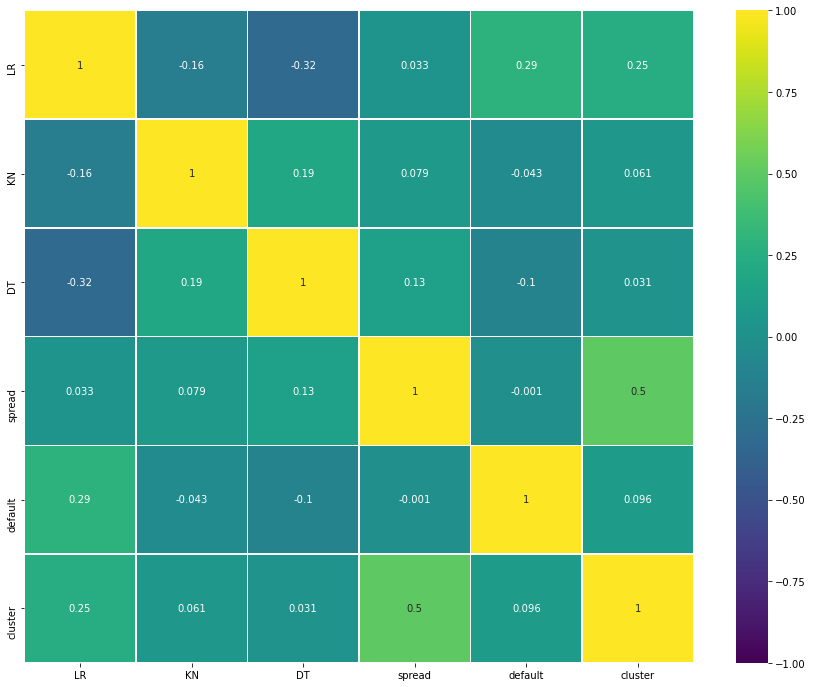

In [191]:
# Корреляционная матрица
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(models_roc_auc.corr(), vmin=-1, vmax=1, annot=True, linewidths=.5, cmap='viridis')

Высоких корреляций не выявлено.

## Построение итоговой модели

In [192]:
# Функция предобработки входных данных
def enhanced_preproc(X):
    models_roc_auc = pd.DataFrame({'LR': best_model.predict_proba(X)[:, 1], 
                              'KN': models['KN']['best_model'].predict_proba(X)[:, 1], 
                              'DT': models['DT']['best_model'].predict_proba(X)[:, 1]})
    
    models_roc_auc['spread'] = models_roc_auc.apply(lambda x: x.max()-x.min(), axis=1)
    
    for i in ['KN','DT']:
        models_roc_auc[i] = models_roc_auc.apply(lambda x: x[i]-x['LR'], axis=1)
    
    models_roc_auc["cluster"] = kmeans_e.predict(models_roc_auc[['LR','spread']])
    models_roc_auc = pd.get_dummies(data=models_roc_auc, columns=['cluster'], prefix = 'c')
    
    return models_roc_auc

In [193]:
# Предобработка, в данном случае тестовая выборка является обучающей
X_e = enhanced_preproc(X_test).values

In [194]:
# Предобработка тестовой выборки
X_e_test = enhanced_preproc(X_tune).values

In [195]:
# Подбор оптимальных гиперпараметров
# Значения гиперпараметров для тестирования
C = [0.01, 0.1, 1, 10]
penalty = ['l1', 'l2']
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
warm_start = [True, False]
class_weight = [None, 'balanced']


# Словарь гиперпараметров
hyperparameters = {'C': C, 'penalty': penalty, 'solver': solver, 
                   'warm_start':warm_start, 'class_weight':class_weight}

model_e = LogisticRegression(random_state = RC, max_iter=25)
model_e.fit(X_e, y_test)

# Создаем сетку поиска с использованием 3-кратной перекрестной проверки
gscv = GridSearchCV(model_e, hyperparameters, cv=3,
                   verbose=1, scoring='roc_auc')
model_e_search = gscv.fit(X_e, y_test)

print()
print('Лучший ROC AUC: \t', model_e_search.best_score_)
print()
for parameter in hyperparameters.keys():
    print('Лучший {}:\t'.format(parameter.upper()),
          model_e_search.best_estimator_.get_params()[parameter])

Fitting 3 folds for each of 160 candidates, totalling 480 fits

Лучший ROC AUC: 	 0.7391360348405334

Лучший C:	 0.1
Лучший PENALTY:	 l1
Лучший SOLVER:	 saga
Лучший WARM_START:	 True
Лучший CLASS_WEIGHT:	 None


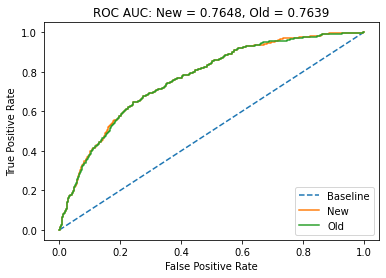

In [196]:
# Сравнивем результат аггрегированной модели с голой регрессией
new_probs = model_e_search.best_estimator_.predict_proba(X_e_test)
new_probs = new_probs[:,1]
old_probs = best_model.predict_proba(X_tune)
old_probs = old_probs[:,1]

new_fpr, new_tpr, new_threshold = roc_curve(y_tune, new_probs)
new_roc_auc = roc_auc_score(y_tune, new_probs)
old_fpr, old_tpr, old_threshold = roc_curve(y_tune, old_probs)
old_roc_auc = roc_auc_score(y_tune, old_probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(new_fpr, new_tpr, label = 'New')
plt.plot(old_fpr, old_tpr, label = 'Old')
plt.title('ROC AUC: New = {}, Old = {}'.format(round(new_roc_auc,4),round(old_roc_auc,4)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

На тестовой выборке есть незначительное улучшение результата (<0.001 ROC AUC)

## Повторный submission

In [197]:
# Предсказание вероятности для валидауионной выборки (Kaggle)
probs_e = model_e_search.best_estimator_.predict_proba(enhanced_preproc(X_valid).values)
probs_e = MinMaxScaler().fit_transform(probs_e)[:, 1]

In [198]:
result_e = pd.DataFrame({'client_id': client_id, 'default': probs_e})

In [199]:
result_e

client_id   default
0          74835  0.033800
1          17527  0.627793
2          75683  0.071167
3          26883  0.162390
4          28862  0.025856
...          ...       ...
36344      83775  0.682955
36345     106254  0.010858
36346      81852  0.675739
36347       1971  0.465191
36348      69044  0.552710

[36349 rows x 2 columns]

In [200]:
result_e.to_csv('submission.csv', index = False)

In [201]:
compare = pd.DataFrame({'1st':result.default, '2nd':result_e.default})

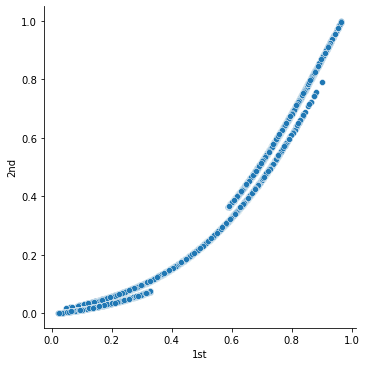

In [202]:
sns.relplot(data=compare, x='1st', y='2nd', palette = 'viridis')

Как видно из графика, есть искривление вероятности, кластеризация разбила предсказания на подклассы.

In [203]:
result_e.to_csv('submission.csv', index = False)

Итоговый результат на валидационной выборке (Kaggle), ROC AUC = 0.73988.